In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import  numpy as np
from itertools import product


import pickle
import numpy as np
import os

import plotly.express as px

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans

#import ttestid
from scipy.stats import ttest_ind

import warnings

#import gaussian filter 1d

from scipy.ndimage import gaussian_filter1d
import pandas as pd

pd.options.mode.chained_assignment = None  # Suppresses chained assignment warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Utils function

In [2]:
def extractDf(dfPlotTrajectory, obstacle, view, haptics):
    dfplot = dfPlotTrajectory.query(f"Obs == '{obstacle}' & View == '{view}' & Haptics == '{haptics}'")[[ "Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation"]]
    return dfplot

def compute_network_path(kmeans, startClust, endClust):
    centers = kmeans.cluster_centers_
    G = nx.Graph()
    
    # Add each cluster center as a node in the graph.
    for i, c in enumerate(centers):
        G.add_node(i, pos=c)
    
    # Identify indices of the start and end clusters.
    start_index = np.where((centers == startClust).all(axis=1))[0][0]
    end_index   = np.where((centers == endClust).all(axis=1))[0][0]
    
    # For each cluster (except start and end), connect to its two closest clusters.
    for i, c in enumerate(centers):
        if i == start_index or i == end_index:
            continue  # Skip the start and end clusters.
        dists = distance.cdist([c], centers)[0]
        sorted_indices = np.argsort(dists)
        # The closest is itself (distance 0), so take the next two.
        for j in sorted_indices[1:3]:
            G.add_edge(i, j, weight=dists[j])
    
    # For the start cluster, add an edge to its nearest neighbor (ignoring itself).
    dists = distance.cdist([startClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(start_index, neighbor, weight=dists[neighbor])
    
    # For the end cluster, add an edge to its nearest neighbor.
    dists = distance.cdist([endClust], centers)[0]
    sorted_indices = np.argsort(dists)
    neighbor = sorted_indices[1]
    G.add_edge(end_index, neighbor, weight=dists[neighbor])
    
    # Ensure connectivity: if the graph is not connected, iteratively add edges
    # connecting the separate components with the smallest possible distances.
    if not nx.is_connected(G):
        # Get the list of connected components.
        components = list(nx.connected_components(G))
        # Continue until we have a single connected graph.
        while len(components) > 1:
            best_edge = None
            best_weight = np.inf
            # Check pairs: one node from the first component and one node from any other.
            for i in components[0]:
                for comp in components[1:]:
                    for j in comp:
                        # Compute Euclidean distance between centers.
                        w = np.linalg.norm(centers[i] - centers[j])
                        if w < best_weight:
                            best_weight = w
                            best_edge = (i, j)
            # Add the best edge found to join two components.
            if best_edge is not None:
                G.add_edge(best_edge[0], best_edge[1], weight=best_weight)
            # Update the list of connected components.
            components = list(nx.connected_components(G))
    
    # Compute the shortest path from the start to end cluster.
    path_indices = nx.shortest_path(G, source=start_index, target=end_index, weight='weight')
    
    # Convert node indices back to coordinates.
    path_coords = [centers[i] for i in path_indices]
    return path_coords

def get_progress(x, y, path):
    """
    Compute a progress index (0 = start, 1 = end) for a given point (x, y) along a path.
    
    The path is assumed to be an ordered list of points (each as [x, y]). The function works by
    projecting the point onto each segment of the path and selecting the projection with the minimum distance.
    Then it calculates the cumulative distance from the start of the path to that projection and normalizes by
    the total path length.
    
    Parameters:
        x, y : Coordinates of the query point.
        path : Ordered list of points (each as [x, y]) defining the path from start to end.
    
    Returns:
        progress : A float between 0 (at the start) and 1 (at the end) indicating the point's relative position along the path.
    """
    P = np.array([x, y])
    
    # Compute cumulative distances along the path.
    cumulative = [0]
    total_length = 0
    for i in range(1, len(path)):
        seg_length = np.linalg.norm(np.array(path[i]) - np.array(path[i-1]))
        total_length += seg_length
        cumulative.append(total_length)
    
    # Project P onto each segment and find the closest projection.
    min_dist = float('inf')
    proj_length = None  # Distance along the path corresponding to the best projection.
    for i in range(1, len(path)):
        A = np.array(path[i-1])
        B = np.array(path[i])
        AB = B - A
        seg_len_sq = np.dot(AB, AB)
        if seg_len_sq == 0:  # Degenerate segment.
            continue
        t = np.dot(P - A, AB) / seg_len_sq
        t_clamped = np.clip(t, 0, 1)
        proj = A + t_clamped * AB  # Projection of P onto segment [A, B]
        d = np.linalg.norm(P - proj)
        if d < min_dist:
            min_dist = d
            seg_length = np.linalg.norm(AB)
            proj_length = cumulative[i-1] + t_clamped * seg_length

    if proj_length is None:
        return 0.0
    
    if proj_length > total_length:
        return 1.0
    
    
    progress = proj_length / total_length
    return progress

def defineProgress(dfPlotTraj, obstacle, view, haptics, path):

    dfplot = extractDf(dfPlotTraj, obstacle, view, haptics)
    dfplot.dropna(inplace=True)

    dfplot["progress"] = dfplot.apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1)

    dfplot["progressBin"] = pd.cut(dfplot["progress"], bins=60)
    dfplot["meanPosXReal"] = dfplot["meanPosX"].astype(float)
    dfplot["meanPosYReal"] = dfplot["meanPosZ"].astype(float)

    dfplotFinal = dfplot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()

    color = dfplot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]

    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    return dfplot, dfplotFinal

def violinGraphSituation(df, metric):
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []

    prev_view_obstacle = None
    for (view, obstacle), subset in grouped:
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        pos_counter += 1

        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        pos_counter += 1

        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)  # Adjust separator position
        prev_view_obstacle = (view, obstacle)
    
    plt.figure(figsize=(12, 6))
    violin_parts = plt.violinplot(dataset=all_data, positions=positions, showmeans=True)
    
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

    for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        vp = violin_parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
    
    for sep in scenario_separators:
        plt.axvline(x=sep-0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Violin Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()

def boxPlotSituation(df, metric):
    # Group data by View and Obstacle
    grouped = df.groupby(["View", "Obstacle"])
    
    all_data = []
    positions = []
    x_labels = []
    colors = []
    pos_counter = 1
    scenario_separators = []
    prev_view_obstacle = None
    
    plt.figure(figsize=(12, 6))
    
    # Iterate over each (view, obstacle) group
    for (view, obstacle), subset in grouped:
        # Extract data for H and NH
        h_times = subset[subset["Haptics"] == "H"][metric].values
        nh_times = subset[subset["Haptics"] == "NH"][metric].values
        
        h_count = len(h_times)
        nh_count = len(nh_times)
        
        # Collect data & positions for the box plot
        all_data.append(h_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-H\n(n={h_count})")
        colors.append("red")
        h_pos = pos_counter
        pos_counter += 1
        
        all_data.append(nh_times)
        positions.append(pos_counter)
        x_labels.append(f"{view}-{obstacle}-NH\n(n={nh_count})")
        colors.append("blue")
        nh_pos = pos_counter
        pos_counter += 1
        
        # Insert vertical separators between scenarios
        if prev_view_obstacle is not None and prev_view_obstacle != (view, obstacle):
            scenario_separators.append(pos_counter - 2)
        prev_view_obstacle = (view, obstacle)
        
        # ---- Compute and annotate p-values ----
        # Only compute p-value if we have data in both groups
        if h_count > 0 and nh_count > 0:
            stat, p_val = ttest_ind(h_times, nh_times, equal_var=False)
            
            # Create text label for p-value
            p_text = f"p={p_val:.3g}"
            if p_val < 0.001:
                p_text += " **"
            elif p_val < 0.05:
                p_text += " *"
            
            # Determine where to place the p-value text
            ax = plt.gca()
            # Put the p-value slightly above the max of the two groups
            max_y = max(h_times.max(), nh_times.max())
            y_pos = max_y * 1.05
            # Midpoint between H and NH on the x-axis
            x_mid = (h_pos + nh_pos) / 2.0
            
            ax.text(
                x_mid, 
                y_pos, 
                p_text, 
                ha='center', 
                va='center', 
                color='black'
            )
    
    # Draw the box plot
    box_parts = plt.boxplot(all_data, positions=positions, patch_artist=True, showmeans=True)
    
    # Color each box (red for H, blue for NH)
    for i, box in enumerate(box_parts['boxes']):
        box.set_facecolor(colors[i])
        box.set_edgecolor('black')
        box.set_alpha(0.7)
    
    # Draw vertical separators for different (View, Obstacle) pairs
    for sep in scenario_separators:
        plt.axvline(x=sep - 0.5, color='black', linestyle='--', linewidth=1)
    
    plt.xticks(positions, x_labels, rotation=45, ha='right')
    plt.xlabel("View - Obstacle - Haptics")
    plt.ylabel(metric)
    plt.title(f"Box Plot of {metric} by View, Obstacle, and Haptics (H=Red, NH=Blue)")
    plt.tight_layout()
    plt.show()



def plot_path_analysis_speed(dfPlot, title):
    fig, axes = plt.subplots(1,5, figsize=(50, 10))
    
    # Scatter plot
    axes[0].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'ro', label="Haptic", markersize=0.5)
    axes[0].legend()
    axes[0].set_title("Scatter Plot")
    
    # Heatmap
    axes[1].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[1].set_title("Heatmap")
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=60, n_init=10)
    kmeans.fit(dfPlot[["meanPosX", "meanPosZ"]])
    
    axes[2].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)
    axes[2].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red')
    axes[2].set_title("KMeans Clustering")
    
    # Path Visualization
    dfPlot.dropna(inplace=True)

    
    startClust = dfPlot.iloc[0][["meanPosX", "meanPosZ"]].values.astype(float)
    endClust   = dfPlot.iloc[-1][["meanPosX", "meanPosZ"]].values.astype(float)

    print(startClust, "   ", endClust)

    print(distance.cdist([startClust], kmeans.cluster_centers_).argmin())

    startClust = kmeans.cluster_centers_[distance.cdist([startClust], kmeans.cluster_centers_).argmin()];
    endClust = kmeans.cluster_centers_[distance.cdist([endClust], kmeans.cluster_centers_).argmin()];
    
    path = compute_network_path(kmeans, startClust, endClust)


    
    for i in range(len(path) - 1):
        progress = get_progress(path[i][0], path[i][1], path)
        color = (1 - progress, progress, 0)
        axes[3].plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'o-', color=color)
    
    axes[3].plot([startClust[0], endClust[0]], [startClust[1], endClust[1]], 'bo')
    axes[3].set_title("Path with Of Progression")

    axes[3].hist2d(dfPlot["meanPosX"], dfPlot["meanPosZ"], bins=100)


    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["meanPosXReal"]].count().reset_index()
    color["meanPosXReal"] = (color["meanPosXReal"] - color["meanPosXReal"].min()) / (color["meanPosXReal"].nlargest(2).iloc[-1] - color["meanPosXReal"].min())
    color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Compute an average color for each segment
    seg_colors = (c[:-1] + c[1:]) / 2

    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 1))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes[4].add_collection(lc)
    plt.colorbar(lc, ax=axes[4], label="Gradient Value")

    # Also plot the Haptic points
    axes[4].plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes[4].set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def showPlot(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_speed(dfTrajectory.iloc[index]["FlightState"], title)

def plot_path_analysis_spread(dfPlot, title):
    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    dfplotFinal = dfPlot.groupby("progressBin")[["meanPosXReal", "meanPosYReal", "desiredSeparation"]].mean().reset_index()


    color = dfPlot.groupby("progressBin")[["desiredSeparation"]].mean().reset_index()
   # color["meanPosXReal"] = (color["desiredSeparation"] - color["desiredSeparation"].min()) / (color["desiredSeparation"].max() - color["desiredSeparation"].min())
    color["meanPosXReal"] = color["desiredSeparation"]
    #color["meanPosXReal"] = color["meanPosXReal"].clip(0, 1)

    #make the color from green to red
    color["color"] = color["meanPosXReal"]


    dfplotFinal = dfplotFinal.merge(color[["progressBin", "color"]], on="progressBin")

    # Get the values from your DataFrame
    x = dfplotFinal["meanPosXReal"].values
    y = dfplotFinal["meanPosYReal"].values
    c = dfplotFinal["color"].values  # these should be values between 0 and 1

    # Create line segments from the x,y points.
    # Each segment is defined by two consecutive points.
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    # Create a LineCollection. The cmap 'viridis' will be used,
    # and the norm ensures the colormap spans from 0 to 1.
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['green', 'red'])

    # Number of interpolation steps per segment (higher = smoother gradient)
    num_interp = 10  

    # Create interpolated segments and colors
    new_segments = []
    new_colors = []

    for i in range(len(x) - 1):
        # Linearly interpolate points along the segment
        interp_x = np.linspace(x[i], x[i+1], num_interp)
        interp_y = np.linspace(y[i], y[i+1], num_interp)
        
        # Linearly interpolate colors for smooth transition
        interp_c = np.linspace(c[i], c[i+1], num_interp)

        # Create the sub-segments
        for j in range(num_interp - 1):
            new_segments.append([[interp_x[j], interp_y[j]], [interp_x[j+1], interp_y[j+1]]])
            new_colors.append(interp_c[j])  # Assign color gradually along the segment

    # Convert to NumPy array for `LineCollection`
    new_segments = np.array(new_segments)

    # Create the LineCollection with the interpolated color map
    lc = LineCollection(new_segments, cmap=custom_cmap, norm=plt.Normalize(0, 5))
    lc.set_array(np.array(new_colors))
    lc.set_linewidth(2)

    # Plotting the gradient line
    axes.add_collection(lc)
    
    plt.colorbar(lc, ax=axes, label="Spreadness")

    # Also plot the Haptic points
    axes.plot(dfPlot["meanPosX"], dfPlot["meanPosZ"], 'o', markersize=0.5, alpha=0.05, color='blue')

    axes.set_title("Gradient Line for speed")

    #STE THE main title

    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def showPlot_spread(index, dfTrajectory):
    title = f"Path Progression for {dfTrajectory.iloc[index]["Obstacle"]} - {dfTrajectory.iloc[index]["View"]} - {dfTrajectory.iloc[index]["Haptics"]}"
    plot_path_analysis_spread(dfTrajectory.iloc[index]["FlightState"], title)

def plot_crash_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["FPV"]
    haptics = ["H", "NH"]

    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["Crash"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states.groupby("ProgressBars").count()["progress"] / len(flight_states)
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values
        })

        # the index is supposed to go from 0 to 100 if there is no value for a progress bar, we need to add it to 0
        newdf = newdf.set_index("ProgressBars").reindex(range(101)).fillna(0).reset_index()
        


        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.17, obstacle_name,
                    ha="center", va="center", fontsize=5, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Crashes Density")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

def plot_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["TDV", "FPV"]
    haptics = ["H", "NH"]
    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["FlightState"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states.groupby("ProgressBars").count()["swarmConnectivness"] / len(flight_states)
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values
        })

        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.2, obstacle_name,
                    ha="center", va="center", fontsize=8, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Density")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

def plot_spreadness_path_analysis_minmax(dfTrajectory):

    fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle("Path Progression Analysis (Shared Min–Max Scale for H/NH)", fontsize=16)

    obstacles = ["Obstacle", "Collectibles"]
    views = ["TDV", "FPV"]
    haptics = ["H", "NH"]
    # -----------------------------------------------------------------
    # 1) First pass: Collect all distributions in a dictionary so we can
    #    find the min and max across H and NH for each (View, Obstacle).
    # -----------------------------------------------------------------

    data_dict = {}

    for view, haptic, obstacle in product(views, haptics, obstacles):
        # Filter your main dataframe to the relevant subset
        df_sub = dfTrajectory[
            (dfTrajectory["View"] == view) &
            (dfTrajectory["Haptics"] == haptic) &
            (dfTrajectory["Obstacle"] == obstacle)
        ]

        if df_sub.empty:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Take the first row for this combination
        row_data = df_sub.iloc[0]
        flight_states = row_data["FlightState"]  # This is presumably a DataFrame
        if len(flight_states) == 0:
            data_dict[(view, haptic, obstacle)] = None
            continue

        # Group by progress and compute normalized counts
        vals = flight_states[['desiredSeparation', 'ProgressBars']].groupby("ProgressBars").mean()
        newdf = pd.DataFrame({
            "ProgressBars": vals.index,
            "Value": vals.values.reshape(-1)
        })

        # Smooth with a Gaussian filter
        newdf["Value"] = gaussian_filter1d(newdf["Value"], sigma=4)

        data_dict[(view, haptic, obstacle)] = newdf

    # Now figure out the (min, max) across H & NH for each (view, obstacle)
    scale_dict = {}
    for view, obstacle in product(views, obstacles):
        df_H = data_dict.get((view, "H", obstacle))
        df_NH = data_dict.get((view, "NH", obstacle))

        all_vals = []
        if df_H is not None:
            all_vals.append(df_H["Value"].values)
        if df_NH is not None:
            all_vals.append(df_NH["Value"].values)

        if len(all_vals) > 0:
            # Use numpy directly
            all_vals = np.concatenate(all_vals)
            vmin = all_vals.min()
            vmax = all_vals.max()
        else:
            vmin, vmax = 0, 0

        scale_dict[(view, obstacle)] = (vmin, vmax)

    # -----------------------------------------------------------------
    # 2) Second pass: Create subplots, applying the same vmin/vmax
    #    for H and NH for each (view, obstacle).
    # -----------------------------------------------------------------
    for col, obstacle in enumerate(obstacles):
        for i, (view, haptic) in enumerate(product(views, haptics)):
            ax = axes[i, col]  # 4 rows, 2 columns

            newdf = data_dict.get((view, haptic, obstacle))
            if newdf is None or newdf.empty:
                ax.set_title(f"No data for {view}-{haptic}-{obstacle}")
                ax.axis("off")
                continue

            vmin, vmax = scale_dict.get((view, obstacle), (0, 0))

            sns.heatmap(
                newdf[["Value"]].T,
                ax=ax,
                cmap="magma",
                cbar=False,
                xticklabels=20,
                vmin=vmin,
                vmax=vmax
            )

            # Annotate obstacle segments
            for obstacle_name, (start, end) in obstacles_map.items():
                mid_point = (start + end) / 2
                ax.text(
                    mid_point, 1.2, obstacle_name,
                    ha="center", va="center", fontsize=8, color="black", fontweight="bold"
                )
                ax.axvline(start, color="green", linestyle="--", linewidth=1)
                ax.axvline(end, color="green", linestyle="--", linewidth=1)

            ax.set_title(f"{view} - {haptic} - {obstacle}")
            ax.set_xlabel("Progress Bars")
            if col == 0:  # Only label y-axis on the leftmost column
                ax.set_ylabel("Spreadness")

    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    plt.show()

def getCrash(df):
    crash = df.groupby("droneId").count()[["Time"]].reset_index()
    maxCrash = crash["Time"].max()

    droneCrash = crash[crash["Time"] != maxCrash][["droneId", "Time"]].values

    dfCrash = pd.DataFrame(columns=["droneId", "Time"])

    for drone in droneCrash:
        timeCrash = df[df["droneId"] == drone[0]]["Time"].max()
        dfCrash.loc[len(dfCrash)] = [drone[0], timeCrash]
        
    return dfCrash

def analyseFile(folderPath, file):
    separators = file.split('_')
    run = 0
    obstacle = ''
    view = ''
    haptics = ''
    order = ''

    if len(separators) == 4:
        run = 1
    elif len(separators) == 5:
        run = 2
    else:
        raise Exception("This is not a valid file")

    if "Obs" in separators[0]:
        obstacle = "Obstacle"
    elif "Collectibles" in separators[0]:
        obstacle = "Collectibles"
    else:
        raise Exception("This is not a valid file")
    
    if "TDV" in separators[0]:
        view = "TDV"
    elif "FPV" in separators[0]:
        view = "FPV"
    else:
        raise Exception("This is not a valid file")
    
    if "NH" in separators[-3]:
        haptics = "NH"
    elif "H" in separators[-3]:
        haptics = "H"
    else:
        raise Exception("This is not a valid file")
    
    if "NO" in separators[-2]:
        order = "NO"
    elif "O" in separators[-2]:
        order = "O"
    else:
        raise Exception("This is not a valid file")
    
    date = separators[-1][:-5]

    file = os.path.join(folderPath, file)

    PID = folderPath.split('\\')[-1]

   # data = pd.read_json(file)
    
    #make a dataframe of the data
    di = {"PID":PID, "Run" : run, "Obstacle" : obstacle, "View" : view, "Haptics" : haptics, "Order" : order, "Date" : date, "File" : file}

    return di

def makeFromFolder(folderPath):
    print(folderPath)
    files = os.listdir(folderPath)
    files = [f for f in files if f.endswith('.json')]
    print(files)
    foreachFile = [analyseFile(folderPath, f) for f in files]
    return foreachFile

def makeFromFolders(folders):
    foreachFolder = [makeFromFolder(f) for f in folders]
    #print(foreachFolder)
    return foreachFolder

def analyseSwarmState(data, time): ### ake data["swarmState"]
    rows = []

    for drone_entry in data:
        drone_entry.keys()
        drone_id = int(drone_entry["droneId"])
        drone_state = drone_entry["droneState"]

#['position', 'velocity', 'FobstacleAvoidance', 'FolfatiSaber', 'Falignment', 'network', 'layer', 'crashedPred']
        positions = drone_state.get("position", [])
        velocities = drone_state.get("velocity", [])
        obstacles = drone_state.get("FobstacleAvoidance", [])
        allignement = drone_state.get("Falignment", [])
        olfati = drone_state.get("FolfatiSaber", [])
        # embodied_list = drone_state.get("embodied", [])
        # selected_list = drone_state.get("selected", [])
        network_list = drone_state.get("network", [])
        layer_list = drone_state.get("layer", [])
        crashedPred_list = drone_state.get("crashedPred", [])

        # Determine how many time steps exist for this drone
        number_of_time_steps = max(
            len(positions),
            len(velocities),
            len(network_list),
            len(obstacles),
            len(olfati),
            len(allignement)
        )

        for i in range(number_of_time_steps):
            # Fetch the position dictionary if it exists, otherwise {}
            if i < len(positions) and isinstance(positions[i], dict):
                pos = positions[i]
                posX = pos.get("x", None)
                posY = pos.get("y", None)
                posZ = pos.get("z", None)
            else:
                posX, posY, posZ = None, None, None

            # Fetch the velocity dictionary if it exists, otherwise {}
            if i < len(velocities) and isinstance(velocities[i], dict):
                vel = velocities[i]
                velX = vel.get("x", None)
                velY = vel.get("y", None)
                velZ = vel.get("z", None)
            else:
                velX, velY, velZ = None, None, None

            if i < len(obstacles) and isinstance(obstacles[i], dict):
                obs = obstacles[i]
                obsX = obs.get("x", None)
                obsY = obs.get("y", None)
                obsZ = obs.get("z", None)

            if i < len(olfati) and isinstance(olfati[i], dict):
                olf = olfati[i]
                olfX = olf.get("x", None)
                olfY = olf.get("y", None)
                olfZ = olf.get("z", None)

            if i < len(allignement) and isinstance(allignement[i], dict):
                all = allignement[i]
                allX = all.get("x", None)
                allY = all.get("y", None)
                allZ = all.get("z", None)

            net = network_list[i] if i < len(network_list) else None
            layer = layer_list[i] if i < len(layer_list) else None
            crashedPred = crashedPred_list[i] if i < len(crashedPred_list) else None

            row_data = {
                "droneId": drone_id,
                "Time": time[i],
                "posX": posX,
                "posY": posY,
                "posZ": posZ,
                "velX": velX,
                "velY": velY,
                "velZ": velZ,
                "obsX": obsX,
                "obsY": obsY,
                "obsZ": obsZ,
                "olfX": olfX,
                "olfY": olfY,
                "olfZ": olfZ,
                "allX": allX,
                "allY": allY,
                "allZ": allZ,
                "network": net,
                "layer": layer,
                "crashedPred": crashedPred
                
            }

            rows.append(row_data)



    df = pd.DataFrame(rows)

    return df

def getInfo(df):

    with open(df["File"], "r") as f: 
        data = json.load(f)

    rows = []

    # Read top-level constants (if you want them in every row)
    max_speed = data.get("maxSpeed", None)
    max_force = data.get("maxForce", None)
    neighbor_radius = data.get("neighborRadius", None)
    maxSpeed = data.get("maxSpeed", None)
    maxForce = data.get("maxForce", None)
    alpha = data.get("alpha", None)
    beta = data.get("beta", None)
    delta = data.get("delta", None)
    cvm = data.get("cvm", None)
    avoidance_radius = data.get("avoidanceRadius", None)
    desiredSeparationToObs = data.get("desiredSeparationToObs", None)
    avoidance_force = data.get("avoidanceForce", None)
    drone_radius = data.get("droneRadius", None)
    damping_factor = data.get("dampingFactor", None)

    constants = {"max_speed": max_speed, "max_force": max_force, "neighbor_radius": neighbor_radius, "maxSpeed": maxSpeed, "maxForce": maxForce, "alpha": alpha, "beta": beta, "delta": delta, "cvm": cvm, "avoidance_radius": avoidance_radius, "desiredSeparationToObs": desiredSeparationToObs, "avoidance_force": avoidance_force, "drone_radius": drone_radius, "damping_factor": damping_factor}

    cameraForward = data.get("cameraForward", None)
    subNetworkNumber = data.get("subNetworkNumber", None)
    idLeader = data.get("idLeader", None)
    isolation = data.get("isolation", None)
    swarmConnectivness = data.get("swarmConnectivness", None)
    time = data.get("time", None)
    alignment = data.get("alignment", None)
    desiredSeparation = data.get("desiredSeparation", None)
    #make a df of the data

    dic = {"Time": time, "cameraForward": cameraForward, "subNetworkNumber": subNetworkNumber, "idLeader": idLeader, "isolation": isolation, "swarmConnectivness": swarmConnectivness, "alignment": alignment, "desiredSeparation": desiredSeparation}
    dfStudy = pd.DataFrame(dic) 



    swarmState = data.get("swarmState", None)
    dfSwarmState = cleanData(analyseSwarmState(swarmState, time))

    stars = data.get("stars", None)
    dfStars = pd.DataFrame(stars)

    dfCrashed = getCrash(dfSwarmState)
    #
    return cleanData(dfStudy), dfStars, constants, dfSwarmState, dfCrashed

def cleanData(df):
    #remove the rows where time  <= 0
    df = df[df["Time"] > 0]
    #remove the rows where time is not a number

    return df

def processAdditionalInfo(dfFolders):
    for index , _ in dfFolders.iterrows():
        print(index, sep=' ', end=' ', flush=True)
        dfFolders.at[index, "Crash"] = pd.DataFrame(columns=["droneId", "Time"])
        dfFolders.at[index, "Study"] = pd.DataFrame(columns=["Time", "cameraForward", "subNetworkNumber", "idLeader", "isolation", "swarmConnectivness", "alignment", "desiredSeparation"])
        dfFolders.at[index, "Stars"] = pd.DataFrame(columns=["droneId", "starId", "starType", "starPosition", "starRadius", "starColor", "starIntensity", "starDirection", "starAngle", "starDistance", "starSpeed", "starTime"])
        dfFolders.at[index, "SwarmState"] = pd.DataFrame(columns=["droneId", "Time", "posX", "posY", "posZ", "velX", "velY", "velZ", "obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", "allX", "allY", "allZ", "network", "layer", "crashedPred"])
        
        dfStudy, dfStars, constants, dfSwarmState, dfCrash = getInfo(dfFolders.loc[index])

        #SETUP
        dfFolders.at[index, "Crash"] = dfCrash
        dfFolders.at[index, "Study"] = dfStudy
        dfFolders.at[index, "Stars"] = dfStars
        dfFolders.at[index, "SwarmState"] = dfSwarmState

        #PLOT METRICS
        dfFolders.at[index, "Constants"] = pd.DataFrame(constants, index=[0])
        dfFolders.at[index, "FinalTime"] = dfStudy["Time"].max()
        dfFolders.at[index, "NumberOfCrash"] = len(dfCrash)

        #ISOLATION TIME
        isolation_time = 1 - dfFolders.at[index, "Study"]["isolation"].value_counts().loc[0] / len(dfFolders.at[index, "Study"])
        dfFolders.at[index, "isolationTime"] = isolation_time

        #TRAJECTORY
        dfFolders.at[index, "Study"]["meanPosX"] = np.nan
        dfFolders.at[index, "Study"]["meanPosY"] = np.nan
        dfFolders.at[index, "Study"]["meanPosZ"] = np.nan
        mean_values = dfFolders.at[index, "SwarmState"].groupby("Time")[["posX", "posY", "posZ"]].mean().reset_index()
        dfFolders.at[index, "Study"]["meanPosX"][:-1] = mean_values["posX"].values;
        dfFolders.at[index, "Study"]["meanPosY"][:-1] = mean_values["posY"].values;
        dfFolders.at[index, "Study"]["meanPosZ"][:-1] = mean_values["posZ"].values;

        ## STAR 
        idLeader = []
        postionLeader = []
        for i in range(len(dfFolders.at[index, "Stars"])):
            time = dfFolders.at[index, "Stars"].iloc[i]["timeCollected"]
            indexTime = dfFolders.at[index, "Study"].apply(lambda row: np.abs(time - row["Time"]), axis=1).argmin()
            idLeader.append(dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"])

            timeRecorded = dfFolders.at[index, "Study"].iloc[indexTime]["Time"]
            pos = dfFolders.at[index, "SwarmState"].query(f"Time == {timeRecorded} & droneId == {dfFolders.at[index, "Study"].iloc[indexTime]["idLeader"]}")[["posX", "posY", "posZ"]].values;
            if len(pos) == 0:
                postionLeader.append([np.nan, np.nan, np.nan])
            elif len(pos) == 1:
                postionLeader.append(pos[0])
            else:
                print("ERROR")
                postionLeader.append(pos[0])

        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["idLeader"] = idLeader
            dfFolders.at[index, "Stars"]["postionLeader"] = postionLeader
            dfFolders.at[index, "Stars"]["isLeader"] = dfFolders.at[index, "Stars"].apply(lambda row: row["droneId"] == row["idLeader"], axis=1)
            dfFolders.at[index, "leaderPercentage"] = float(dfFolders.at[index, "Stars"]["isLeader"].sum() / len(dfFolders.at[index, "Stars"]))
        else:
            dfFolders.at[index, "leaderPercentage"] = 0

        
        if(len(dfFolders.at[index, "Stars"]) > 0):
            dfFolders.at[index, "Stars"]["positionArray"] = dfFolders.at[index, "Stars"]["position"].apply(lambda row: [row["x"], row["y"], row["z"]])
            dfFolders.at[index, "Stars"]["diffPosition"] = dfFolders.at[index, "Stars"].apply(lambda row: np.linalg.norm(np.array(row["positionArray"]) - np.array(row["postionLeader"])), axis=1)
            dfFolders.at[index, "meanDiffPosition"] = dfFolders.at[index, "Stars"]["diffPosition"].mean()
        else:
            dfFolders.at[index, "meanDiffPosition"] = 0

def setProgress(dfFolders, path):
    
    for index, df in dfFolders.iterrows():
        print(index, sep=' ', end=' ', flush=True)
        df["Study"]["Progress"] = 0
        values = df["Study"].apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1).values
        df["Study"]["Progress"] = values

def groupedConditions(dfFolders, path, condition):
    print(condition)
    dfConditions = pd.DataFrame(columns=["Obstacle", "View", "Haptics", "FlightState"])
    dfPlotTrajectory = pd.DataFrame(columns=["Time", "meanPosX", "meanPosY", "meanPosZ", "Obs", "View", "Haptics", "desiredSeparation"])

    for _, df in dfFolders.iterrows():
        df["Study"]["Progress"] = 0
        df["Study"]["Progress"] = df["Study"].apply(lambda row: get_progress(row["meanPosX"], row["meanPosZ"], path), axis=1).values
        # dfAdded = df["Study"][["Time", "meanPosX", "meanPosY", "meanPosZ", "desiredSeparation", "Progress"]]
        # dfAdded["Obs"] = df["Obstacle"]
        # dfAdded["View"] = df["View"]
        # dfAdded["Haptics"] = df["Haptics"]

   #     dfPlotTrajectory = pd.concat([dfPlotTrajectory, dfAdded])


  ##  dfPlot, _ = defineProgress(dfPlotTrajectory, condition[0], condition[1], condition[2], path)

 #   dfConditions.at[0, "Obstacle"] = condition[0]
 #   dfConditions.at[0, "View"] = condition[1]
 #   dfConditions.at[0, "Haptics"] = condition[2]
   # dfConditions.at[0, "FlightState"] = dfPlot

    return dfConditions, dfPlotTrajectory



def setQuestionnaire(dfFolders):
    #read csv file
    questionnaire = pd.read_csv("Assets\Data\questionnaire.csv")

    # find index PID in questionnaire.columns
    indexPID = questionnaire.columns.get_loc("PID")
    indexQ1 = questionnaire.columns.get_loc("Q1_1")

    #make list going from indexPID to indexQ1
    columns = list(range( indexQ1, indexPID+1))
    #Keep first row and then from 3 to the last row
    rows = list(range(2, len(questionnaire)))

    dfQuestionnaire = questionnaire.iloc[rows, columns]
    # Go row by row in your questionnaire DataFrame
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            continue
        
        print(indexQuestionnaire, ":", PID)

        # Check Order from the matching row in dfFolders
        dfFolderQuestionnaire = dfFolders[dfFolders["PID"] == PID].iloc[0]
        Order = (dfFolderQuestionnaire["Order"] == 'O')
        
        # Decide question order based on 'Order'
        if Order:
            questionOrder = ["TDV", "FPV"]
        else:
            questionOrder = ["FPV", "TDV"]


        indexVal = 0 
        for obstacle_type in ["Obstacle", "Collectibles"]:
            for view_type in questionOrder:
                for k in range(6):
                    # Read value from the appropriate column of dfQ
                    value = dfQ[dfQuestionnaire.columns[indexVal]]
                    
                    modIndex = indexVal % 6
                    if modIndex == 0:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "MentalyDemanding"
                        ] = value
                    elif modIndex == 1:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "PhysicalDemanding"
                        ] = value
                    elif modIndex == 2:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Hurry"
                        ] = value
                    elif modIndex == 3:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Effort"
                        ] = value
                    elif modIndex == 4:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Frustration"
                        ] = value
                    elif modIndex == 5:
                        dfFolders.loc[
                            (dfFolders["Obstacle"] == obstacle_type) &
                            (dfFolders["View"] == view_type) &
                            (dfFolders["PID"] == PID),
                            "Success"
                        ] = value
                    else:
                        print("ERROR with modIndex =", modIndex)

                    indexVal += 1

    
    #find the col index of Q14_1
    indexQ14 = dfQuestionnaire.columns.get_loc("Q14_1")
    #Split the columns from Q14_1 to the end
    columns = list(range(indexQ14, len(dfQuestionnaire.columns)))
    dfQuestionnaireRest = dfQuestionnaire.iloc[:, columns]
    
    colName = []
    for hapticFB in ["ObstacleAvoidance", "Spreadness", "Connectivness", "Disconnection", "TrajPred", "Crash"]:
        for dimension in ["Usefulness", "Annoyance", "Intuitivness", "Precission"]:
            colName.append(f"{hapticFB}_{dimension}")

    colName.append("Comments_Haptics")
    colName.append("TDVvsFPV")
    colName.append("TDVvsFPV_Comments")

    #add the rest of the columns as same as the dfQuestionnaireRest
    
    restOfColumns = dfQuestionnaire.columns[indexQ14+len(colName):]
    tempColName = colName + list(restOfColumns)
    dfQuestionnaireRest.columns = tempColName


    indexQ32 = dfQuestionnaireRest.columns.get_loc("TDVvsFPV_Comments")
    indexQ8 = dfQuestionnaireRest.columns.get_loc("Q8")
    #remove the columns from Q32 to Q8
    columns = list(range(0, indexQ32))
    columns = columns + list(range(indexQ8-1, len(dfQuestionnaireRest.columns)))
    dfQuestionnaireRest = dfQuestionnaireRest.iloc[:, columns]

    colName.append("Gender")
    colName.append("Age")
    colName.append("PlayVideoGames")
    colName.append("PlayVideoGamesWeekly")
    colName.append("PlayVideoGamesWeeklyHighest")
    colName.append("ControlOperated")
    colName.append("ControlOperatedHours")
    colName.append("PID")

    print(len(colName), len(dfQuestionnaireRest.columns))

    dfQuestionnaireRest.columns = colName

    allHaptics = []
    for indexQuestionnaire in range(0, len(dfQuestionnaire)):
        
        dfQ = dfQuestionnaire.iloc[indexQuestionnaire]
        PID = dfQ["PID"]
        
        # Ensure PID is in dfFolders
        if PID not in dfFolders["PID"].values:
            print("PID not found for", PID)
            allHaptics.append(np.nan)
            continue
        
        haptics = dfFolders[dfFolders["PID"] == PID].iloc[0]["Haptics"]
        allHaptics.append(haptics)

    dfQuestionnaireRest["Haptics"] = allHaptics
        
    return dfQuestionnaireRest


<>:1195: SyntaxWarning: invalid escape sequence '\D'
<>:1195: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Pablo\AppData\Local\Temp\ipykernel_22504\3075437294.py:1195: SyntaxWarning: invalid escape sequence '\D'
  questionnaire = pd.read_csv("Assets\Data\questionnaire.csv")


# Data anylsis

In [153]:

dfFolders = pd.read_pickle("dfFoldersFinal.pkl")
dfQuestionnaire = pd.read_pickle("dfQuestionnaire.pkl")
dfConditions = pd.read_pickle("dfConditions.pkl")
path = pickle.load(open("path.pkl", "rb"))
   

## Descriptions


## Main observation

In [154]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# --- 1) Compute mean and std grouped by (Obstacle, View, Haptics) ---
metrics = ["FinalTime", "NumberOfCrash", "IsolationTimeMean"]
grouped_stats = (
    dfFolders
    .groupby(["Obstacle", "View", "Haptics"])[metrics]
    .agg(["mean", "std"])
)

# Flatten multi-level column names (("FinalTime","mean") -> "FinalTime_mean")
grouped_stats.columns = [
    f"{col1}_{col2}" for col1, col2 in grouped_stats.columns
]

# --- 2) Compute p-values comparing H vs NH for each (Obstacle, View) pair ---
def compute_pvals(subdf):
    """
    For each (Obstacle, View) subset, extract the H vs NH data
    and run a t-test on FinalTime, NumberOfCrash, and isolationTime.
    """
    # Separate data for H vs NH
    h_data  = subdf[subdf["Haptics"] == "H"]
    nh_data = subdf[subdf["Haptics"] == "NH"]

    # Convert columns to float as necessary
    h_data["FinalTime"] = h_data["FinalTime"].astype(float)
    nh_data["FinalTime"] = nh_data["FinalTime"].astype(float)
    
    # Debug info (optional)
    print(
        "for", subdf["Obstacle"].iloc[0], 
        subdf["View"].iloc[0], 
        "H =", len(h_data), 
        "NH =", len(nh_data),
        "NaNs in H =", h_data["FinalTime"].isna().sum(),
        "NaNs in NH =", nh_data["FinalTime"].isna().sum()
    )
    
    results = {}
    
    # Metrics to test

    for metric in metrics:
        # Only run t-test if at least 2 data points in each group
        if len(h_data[metric]) > 1 and len(nh_data[metric]) > 1:
            _, pval = ttest_ind(h_data[metric], nh_data[metric], nan_policy='omit')
            print(
                f"Computing p-value for {metric}:",
                f"H mean={h_data[metric].mean():.2f}, NH mean={nh_data[metric].mean():.2f},",
                f"H std={h_data[metric].std():.2f}, NH std={nh_data[metric].std():.2f},",
                f"p-value={pval:.4f}"
            )
        else:
            print("Not enough data for", metric, "(skipping t-test)")
            pval = np.nan
        # Store in results dict as p_val_<metric>
        results["p_val_" + metric] = pval
        
    return pd.Series(results)

# Run t-test for each (Obstacle, View) pair and get p-values
pvals = (
    dfFolders
    .groupby(["Obstacle", "View"])
    .apply(compute_pvals)
)

# --- 3) Join p-values with the grouped statistics ---
final_df = grouped_stats.join(
    pvals,
    on=['Obstacle','View'],  # match only Obstacle & View
    how='left'
)

# Reorder columns explicitly so p-values match the correct metrics
final_df = final_df[
    [
        metrics[0]+"_mean",
        metrics[0]+"_std",
        metrics[1]+"_mean",
        metrics[1]+"_std",
        metrics[2]+"_mean",
        metrics[2]+"_std",
        "p_val_"+metrics[0],
        "p_val_"+metrics[1],
        "p_val_"+metrics[2],
    ]
]

# For clarity, rename columns to a simpler form (optional)
final_df.columns = [
    "FinalTime_mean", 
    "FinalTime_std", 
    "NumberOfCrash_mean", 
    "NumberOfCrash_std",
    "isolationTime_mean", 
    "isolationTime_std",
    "p_val_FinalTime", 
    "p_val_NumberOfCrash", 
    "p_val_isolationTime",
]

df = final_df.copy()

# --- 4) Create a pretty table with significance info ---
def get_significance_stars(p):
    """Return a string of asterisks based on p-value thresholds."""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

pretty_data = []

# df has a multi-index of (Obstacle, View, Haptics)
for idx, row in df.iterrows():
    # Unpack row data
    final_mean = row["FinalTime_mean"]
    final_std  = row["FinalTime_std"]
    final_p    = row["p_val_FinalTime"]
    
    crash_mean = row["NumberOfCrash_mean"]
    crash_std  = row["NumberOfCrash_std"]
    crash_p    = row["p_val_NumberOfCrash"]

    iso_mean = row["isolationTime_mean"]
    iso_std  = row["isolationTime_std"]
    iso_p    = row["p_val_isolationTime"]

    # If p-value is NaN, set to 1.0 (no significance)
    if np.isnan(final_p):
        final_p = 1.0
    if np.isnan(crash_p):
        crash_p = 1.0
    if np.isnan(iso_p):
        iso_p = 1.0

    # Create the text with mean ± std, attach significance stars
    final_str = f"{final_mean:.2f} ± {final_std:.2f} {get_significance_stars(final_p)} (p={final_p:.3f})"
    crash_str = f"{crash_mean:.2f} ± {crash_std:.2f} {get_significance_stars(crash_p)} (p={crash_p:.3f})"
    iso_str   = f"{iso_mean:.2f} ± {iso_std:.2f} {get_significance_stars(iso_p)} (p={iso_p:.3f})"
    
    # Retrieve index values
    obstacle, view, haptics = idx

    # Store this row in a list
    pretty_data.append([
        obstacle,
        view,
        haptics,
        final_str,
        crash_str,
        iso_str
    ])

pretty_columns = [
    "Obstacle",
    "View",
    "Haptics",
    "FinalTime (mean ± std)",
    "NumberOfCrash (mean ± std)",
    "isolationTime (mean ± std)",
]

pretty_df = pd.DataFrame(pretty_data, columns=pretty_columns)
pretty_df.set_index(["Obstacle", "View", "Haptics"], inplace=True)

# 'pretty_df' now has the correctly aligned p-values in each metric's column.
pretty_df


for Collectibles FPV H = 37 NH = 36 NaNs in H = 0 NaNs in NH = 0
Computing p-value for FinalTime: H mean=152.55, NH mean=177.49, H std=51.22, NH std=50.53, p-value=0.0399
Computing p-value for NumberOfCrash: H mean=1.32, NH mean=2.58, H std=1.58, NH std=1.73, p-value=0.0018
Computing p-value for IsolationTimeMean: H mean=4.67, NH mean=10.08, H std=7.79, NH std=11.79, p-value=0.0233
for Collectibles TDV H = 35 NH = 36 NaNs in H = 0 NaNs in NH = 0
Computing p-value for FinalTime: H mean=107.27, NH mean=108.59, H std=12.17, NH std=10.14, p-value=0.6220
Computing p-value for NumberOfCrash: H mean=0.17, NH mean=0.19, H std=0.38, NH std=0.40, p-value=0.8054
Computing p-value for IsolationTimeMean: H mean=1.16, NH mean=2.07, H std=1.81, NH std=4.67, p-value=0.2827
for Obstacle FPV H = 35 NH = 37 NaNs in H = 0 NaNs in NH = 0
Computing p-value for FinalTime: H mean=91.11, NH mean=102.34, H std=23.18, NH std=29.02, p-value=0.0749
Computing p-value for NumberOfCrash: H mean=1.23, NH mean=1.81, H 

C:\Users\Pablo\AppData\Local\Temp\ipykernel_22504\3309721985.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_pvals)


FinalTime (mean ± std)  \
Obstacle     View Haptics                               
Collectibles FPV  H        152.55 ± 51.22 * (p=0.040)   
                  NH       177.49 ± 50.53 * (p=0.040)   
             TDV  H         107.27 ± 12.17  (p=0.622)   
                  NH        108.59 ± 10.14  (p=0.622)   
Obstacle     FPV  H          91.11 ± 23.18  (p=0.075)   
                  NH        102.34 ± 29.02  (p=0.075)   
             TDV  H         73.82 ± 9.15 ** (p=0.002)   
                  NH        80.53 ± 8.53 ** (p=0.002)   

                          NumberOfCrash (mean ± std)  \
Obstacle     View Haptics                              
Collectibles FPV  H         1.32 ± 1.58 ** (p=0.002)   
                  NH        2.58 ± 1.73 ** (p=0.002)   
             TDV  H           0.17 ± 0.38  (p=0.805)   
                  NH          0.19 ± 0.40  (p=0.805)   
Obstacle     FPV  H           1.23 ± 1.37  (p=0.115)   
                  NH          1.81 ± 1.70  (p=0.115)   
             TDV  H           0.05 ± 0.23  (p=0.168)   
                  NH          0.15 ± 0.36  (p=0.168)   

                          isolationTime (mean ± std)  
Obstacle     View Haptics                             
Collectibles FPV  H          4.67 ± 7.79 * (p=0.023)  
                  NH       10.08 ± 11.79 * (p=0.023)  
             TDV  H           1.16 ± 1.81  (p=0.283)  
                  NH          2.07 ± 4.67  (p=0.283)  
Obstacle     FPV  H           1.81 ± 4.30  (p=0.471)  
                  NH          2.80 ± 6.91  (p=0.471)  
             TDV  H           0.04 ± 0.27  (p=0.493)  
                  NH          0.14 ± 0.80  (p=0.493)

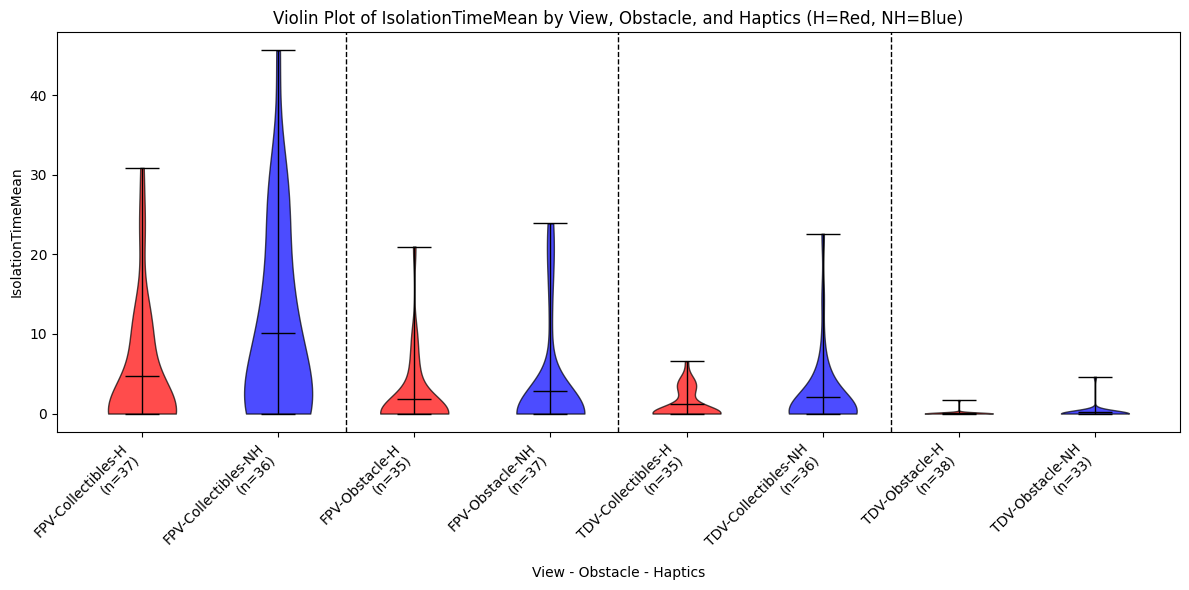

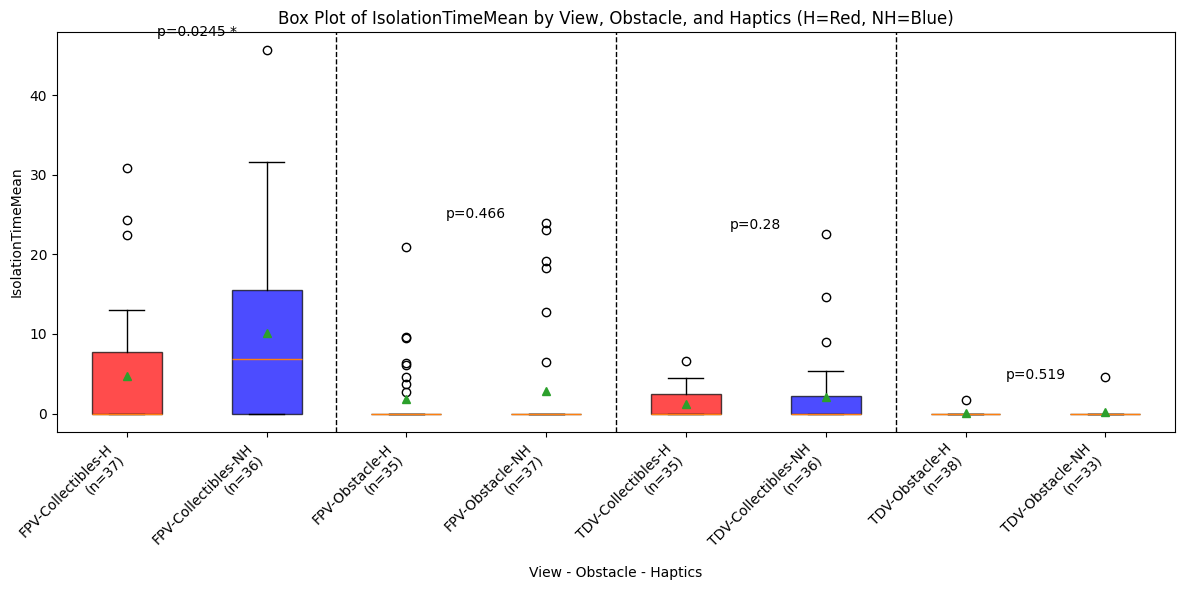

In [155]:
violinGraphSituation(dfFolders, "IsolationTimeMean")
boxPlotSituation(dfFolders, "IsolationTimeMean")

In [156]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# --- 1) Compute mean and std grouped by (Obstacle, View, Haptics) ---
grouped_stats = (
    dfFolders
    .groupby(["Obstacle", "View"])[["FinalTime", "NumberOfCrash"]]
    .agg(["mean", "std"])
)

# --- 2) Compute p-values comparing H vs NH for each (Obstacle, View) pair ---
def compute_pvals(subdf):
    """
    For each (Obstacle, View) subset, extract the H vs NH data
    and run a t-test on FinalTime, NumberOfCrash, and isolationTime.
    """
    # Separate data for H vs NH
    h_data  = subdf[subdf["View"] == "FPV"]
    nh_data = subdf[subdf["View"] == "TDV"]
    
    # We'll store p-values in a dictionary
    results = {}
    
    # For each metric, check we have at least 2 data points in each group
    metrics = ["FinalTime", "NumberOfCrash"]
    for metric in metrics:
        if (len(h_data[metric]) > 1) and (len(nh_data[metric]) > 1):
            _, pval = ttest_ind(h_data[metric], nh_data[metric], nan_policy='omit')
        else:
            pval = np.nan  # Not enough data to test

        results["p_val_" + metric] = pval
        
    return pd.Series(results)

pvals = (
    dfFolders
    .groupby(["Obstacle"])
    .apply(compute_pvals)
)


C:\Users\Pablo\AppData\Local\Temp\ipykernel_22504\1572369423.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_pvals)


In [157]:
dfFolders.groupby(["Obstacle", "View"])["FinalTime"].describe()

count        mean        std        min         25%  \
Obstacle     View                                                        
Collectibles FPV    73.0  164.848662  52.060353  82.707481  126.766586   
             TDV    71.0  107.940955  11.125116  86.608383  101.727596   
Obstacle     FPV    72.0   96.880828  26.766047  60.478851   76.525337   
             TDV    71.0   76.935520   9.426794  56.949398   70.823959   

                          50%         75%         max  
Obstacle     View                                      
Collectibles FPV   151.121414  211.258026  281.850861  
             TDV   107.666801  115.042973  134.901459  
Obstacle     FPV    90.460632  104.570019  162.681213  
             TDV    76.560165   83.254463   97.167175

## trajectory

### Speed

[18.73401484 -8.28862214]     [ -2.41434955 114.51733856]
20


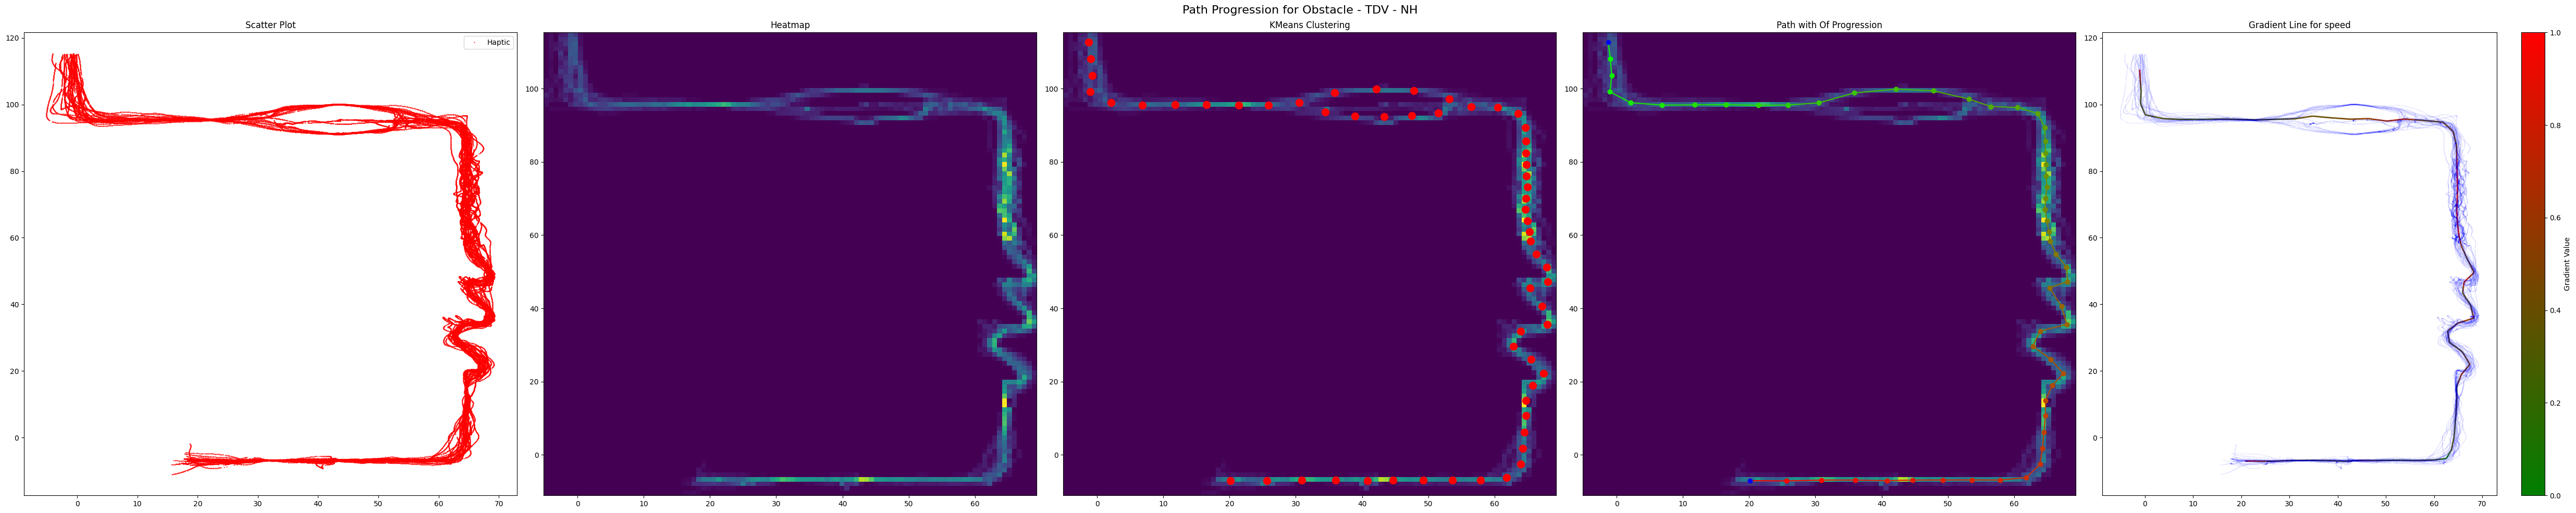

In [158]:
showPlot(1, dfConditions)

### Spread

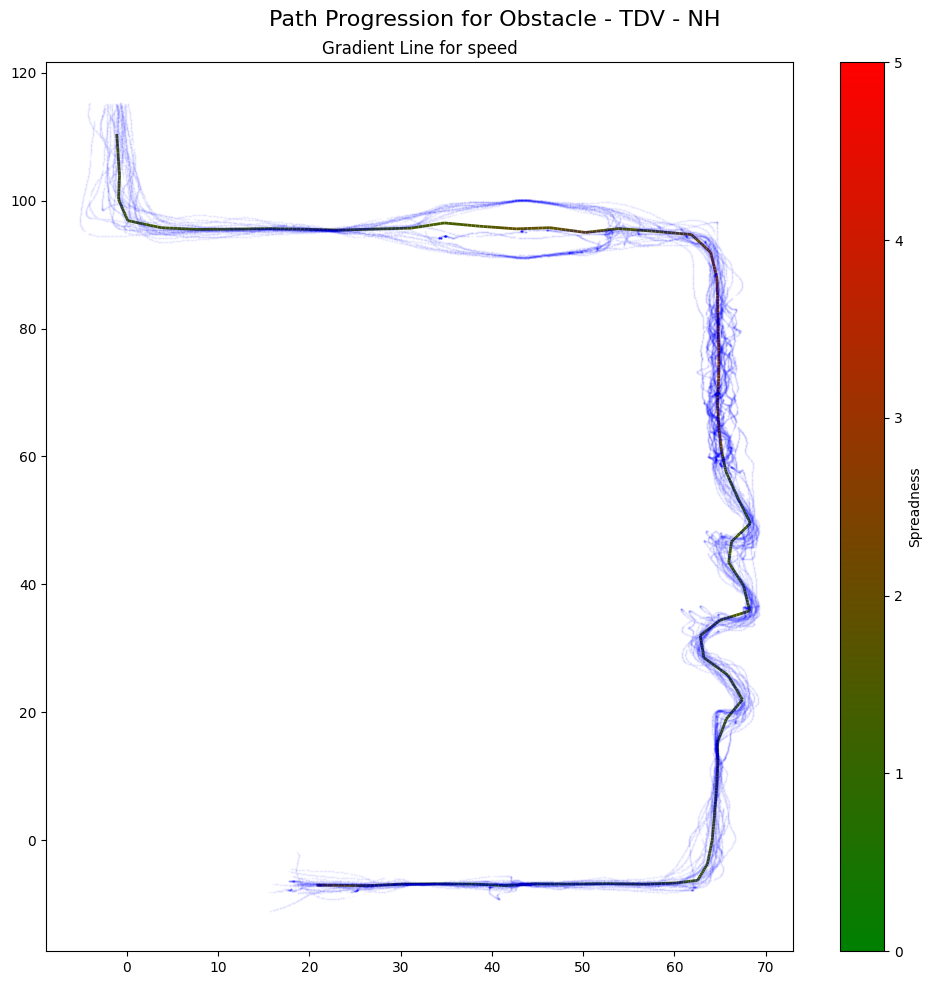

In [159]:
showPlot_spread(1, dfConditions)

## Stars

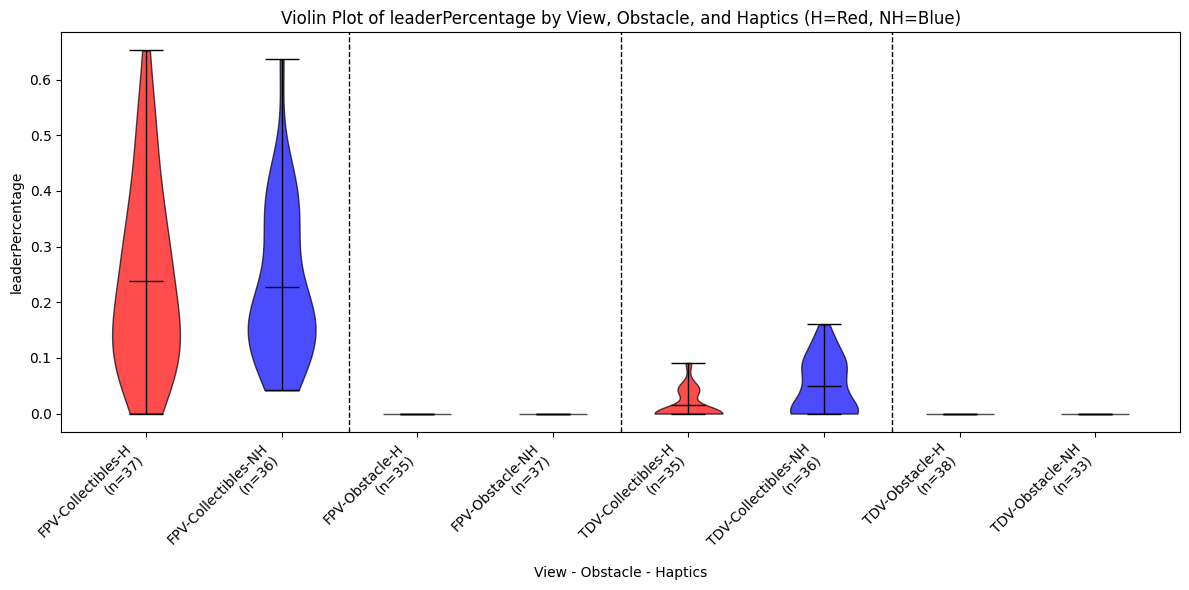

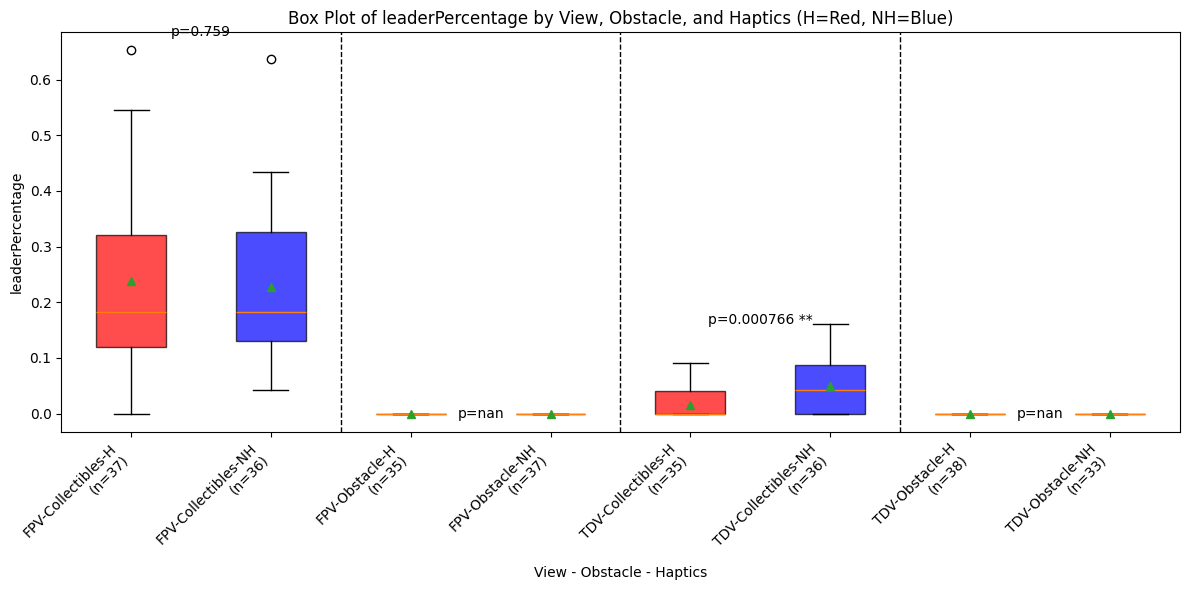

In [160]:
violinGraphSituation(dfFolders, "leaderPercentage")
boxPlotSituation(dfFolders, "leaderPercentage")

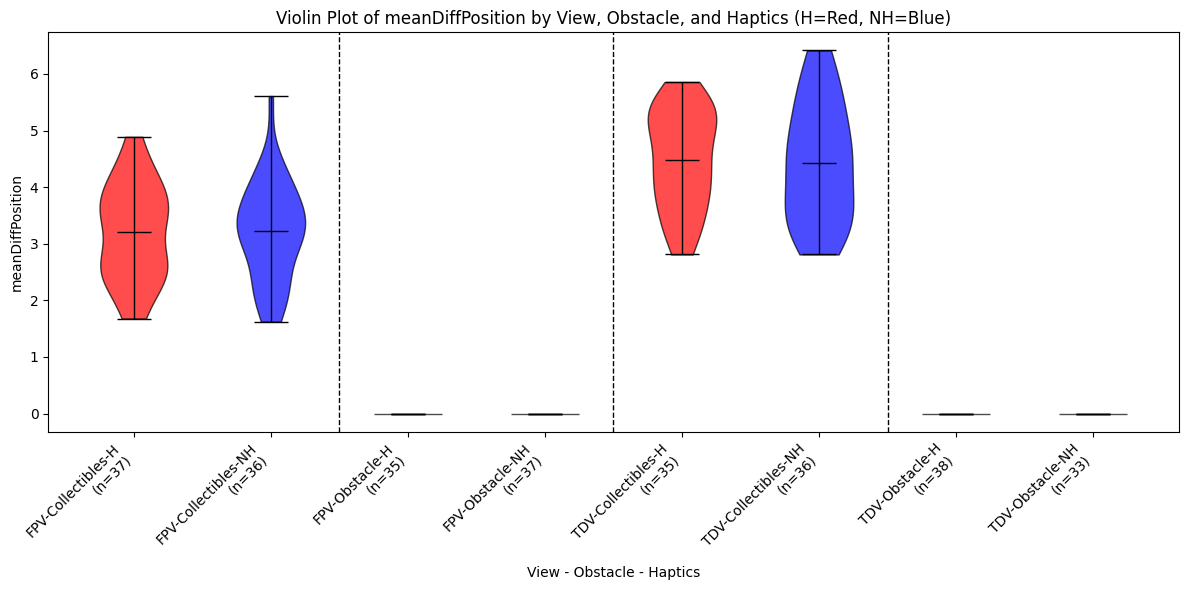

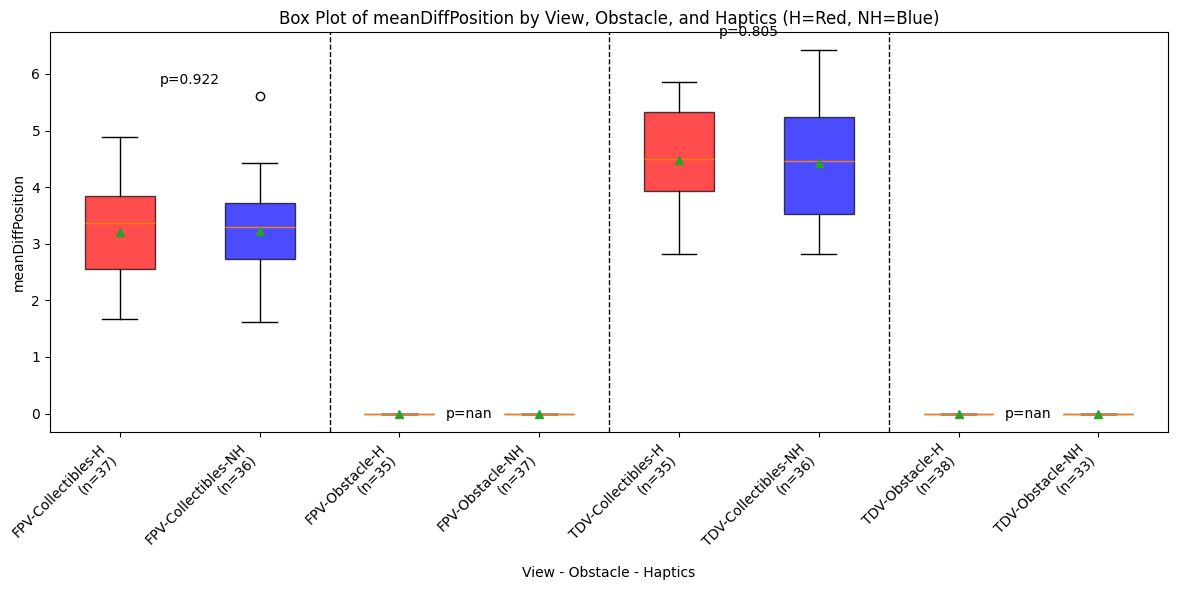

In [161]:
violinGraphSituation(dfFolders, "meanDiffPosition")
boxPlotSituation(dfFolders, "meanDiffPosition")

### stars selection

In [162]:
def update_folder(df, starsId=[7, 8, 6, 1, 4, 5, 15, 16, 22, 21, 23]):
    for idx in df.index:
        # Retrieve the 'Stars' sub-DataFrame from this row
        stars_df = df.at[idx, "Stars"]

        if(stars_df.empty):
            continue

        # 1) Extract/convert "IdStar" from "starName"
        stars_df["IdStar"] = (
            stars_df["starName"]
            .str.extract(r"\((\d+)\)")     # Pull out digits inside parentheses
            .fillna(1)                    # Fill missing with 1
            .astype(int)                  # Convert to int
        )

        # 2) Create a boolean column "selected"
        stars_df["selected"] = stars_df["IdStar"].isin(starsId)

        # 3) For selected stars, compute leaderPercentageSelected
        selected_stars = stars_df[stars_df["selected"]]
        if not selected_stars.empty:
            leader_percentage = selected_stars["isLeader"].sum() / len(selected_stars)
        else:
            leader_percentage = 0

        # 4) For selected stars, compute meanDiffPositionSelected
        mean_diff_position = selected_stars["diffPosition"].mean()

        # Write the sub-DataFrame and computed columns back into df
        df.at[idx, "Stars"] = stars_df
        df.at[idx, "leaderPercentageSelected"] = leader_percentage
        df.at[idx, "meanDiffPositionSelected"] = mean_diff_position


In [163]:
update_folder(dfFolders)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


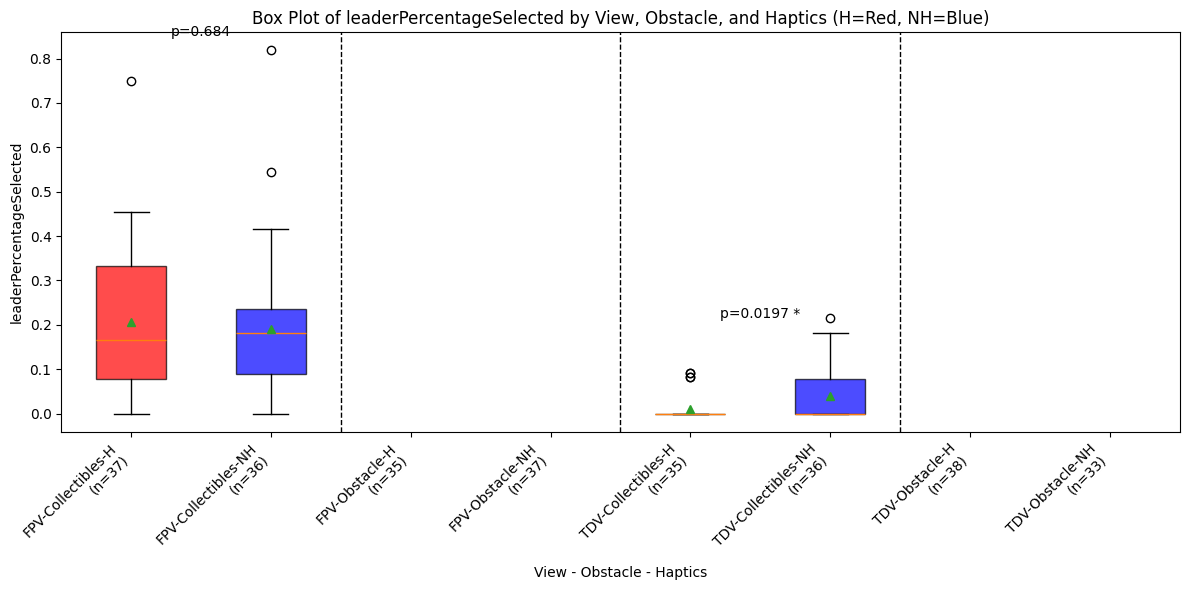

In [164]:
boxPlotSituation(dfFolders, "leaderPercentageSelected")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


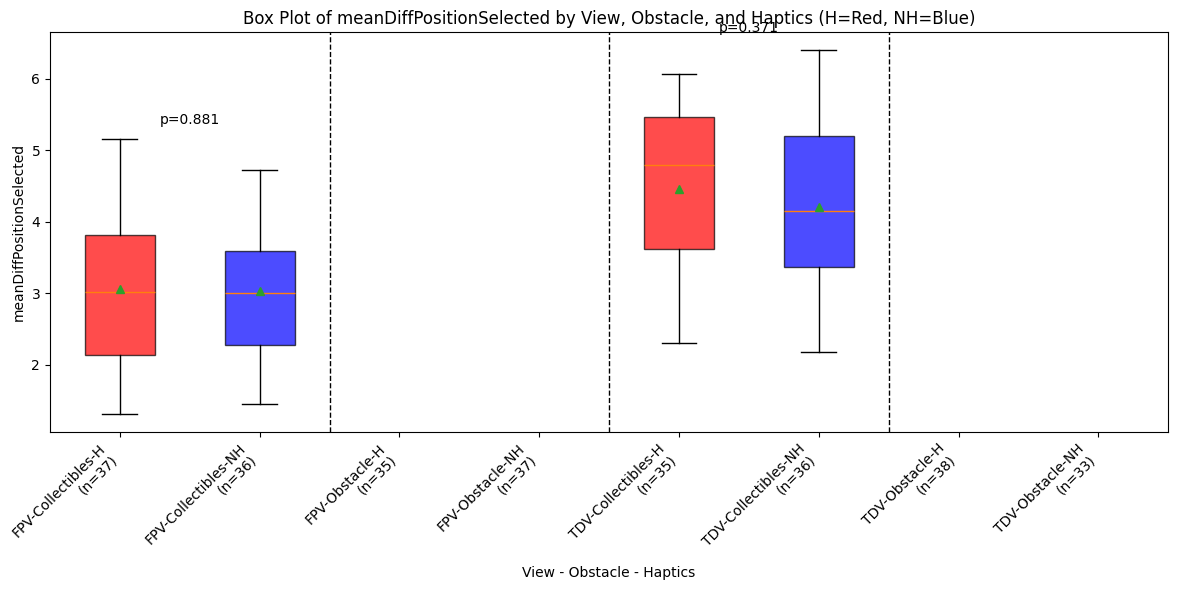

In [165]:
boxPlotSituation(dfFolders, "meanDiffPositionSelected")

## Analysis per portion

### Portion definition

In [166]:
# Define obstacle annotations for the heatmap
obstacles_map = {
        "Gate": [2, 15],
        "ZigZag": [20, 50],
        "Pillars": [50, 70],
        "Diamond": [70, 80],
        "EndGate": [80, 100]
    }


conditions = [["Obstacle", "TDV", "H"], ["Obstacle", "TDV", "NH"], ["Obstacle", "FPV", "H"], ["Obstacle", "FPV", "NH"], ["Collectibles", "TDV", "H"], ["Collectibles", "TDV", "NH"], ["Collectibles", "FPV", "H"], ["Collectibles", "FPV", "NH"]]

In [167]:
def getPortion(x):
    #based on obstacle BASED ON obstacles_map
    for obstacle_name, (start, end) in obstacles_map.items():
        if int(x*100) >= start and x <= end:
            return obstacle_name

    return "Other"

def get_crash_info(df):
    if df["Crash"].empty:
        return

    # create 3 new columns in Crash for the coordinates
    df["Crash"]["posX_crash"] = np.nan
    df["Crash"]["posY_crash"] = np.nan
    df["Crash"]["posZ_crash"] = np.nan
    df["Crash"]["layer"] = -1
    df["Crash"]["progress"] = 0

    for index, row in df["Crash"].iterrows():
        drone_id = row["droneId"]
        swarm_rows = df["SwarmState"].query(f"droneId == {drone_id}")

        if not swarm_rows.empty:
            latest = swarm_rows.iloc[-1]
            df["Crash"].at[index, "posX_crash"] = latest["posX"]
            df["Crash"].at[index, "posY_crash"] = latest["posY"]
            df["Crash"].at[index, "posZ_crash"] = latest["posZ"]
            df["Crash"].at[index, "layer"] = latest["layer"]

            # Compute progress
            df["Crash"].at[index, "progress"] = get_progress(latest["posX"], latest["posZ"], path)

def getTrajectory(df, obstacle, view, haptics):
    selected = df[(df["Obstacle"] == obstacle) & (df["View"] == view) & (df["Haptics"] == haptics)]
    allStudy = []
    allCrash = []
    for _, row in selected.iterrows():
        get_crash_info(row)
        allStudy.append(row["Study"])
        allCrash.append(row["Crash"])

    studies = pd.concat(allStudy).reset_index(drop=True)
    crashes = pd.concat(allCrash).reset_index(drop=True)



    return studies, crashes


for index, row in dfFolders.iterrows():
    get_crash_info(row)
    row["Study"]["ProgressPortion"] = row["Study"]["Progress"].apply(lambda x: getPortion(int(x * 100)))
    if len(row["Crash"]) > 0:
        row["Crash"]["ProgressPortion"] = row["Crash"]["progress"].apply(lambda x: getPortion(int(x * 100)))


allTrajectories = []
dfTrajectory = pd.DataFrame(columns=["Obstacle", "View", "Haptics", "FlightState", "Crash"])

for condition in conditions:
    obstacle, view, haptics = condition
    trajectory, crash = getTrajectory(dfFolders, obstacle, view, haptics)
    dfTrajectory.loc[len(dfTrajectory)] = [obstacle, view, haptics, trajectory, crash]


In [168]:
#rename EndGate to Gate
dfTrajectory["Obstacle"] = dfTrajectory["Obstacle"].replace("EndGate", "Gate")

In [169]:
dfTrajectory

,Obstacle,View,Haptics,FlightState,Crash
0,Obstacle,TDV,H,Time ...,droneId Time posX_crash posY_crash ...
1,Obstacle,TDV,NH,Time ...,droneId Time posX_crash posY_crash ...
2,Obstacle,FPV,H,Time ...,droneId Time posX_crash posY_crash...
3,Obstacle,FPV,NH,Time ...,droneId Time posX_crash posY_crash...
4,Collectibles,TDV,H,Time ...,droneId Time posX_crash posY_crash ...
5,Collectibles,TDV,NH,Time ...,droneId Time posX_crash posY_crash ...
6,Collectibles,FPV,H,Time ...,droneId Time posX_crash posY_cras...
7,Collectibles,FPV,NH,Time ...,droneId Time posX_crash posY_cras...


In [170]:
for index, row in dfTrajectory.iterrows():
    print(index, sep=' ', end=' ', flush=True)
    if len(row["FlightState"]) > 0:
        row["FlightState"]["ProgressBars"] = row["FlightState"]["Progress"].apply(lambda x: int(x * 100))
    if len(row["Crash"]) > 0:
        row["Crash"]["ProgressBars"] = row["Crash"]["progress"].apply(lambda x: int(x * 100))



0 1 2 3 4 5 6 7 

### Graphs path analysis

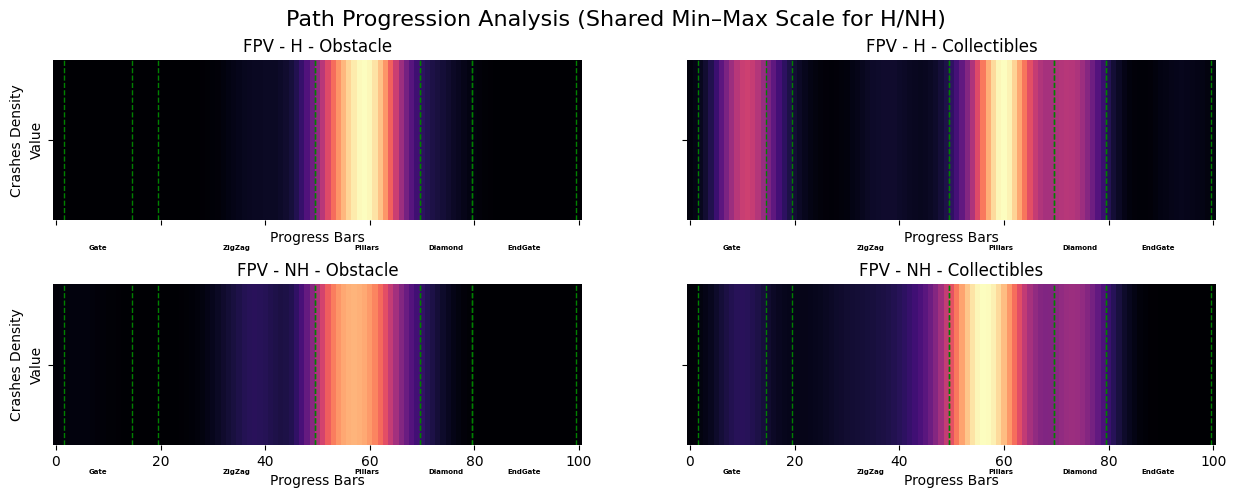

In [171]:
plot_crash_path_analysis_minmax(dfTrajectory)

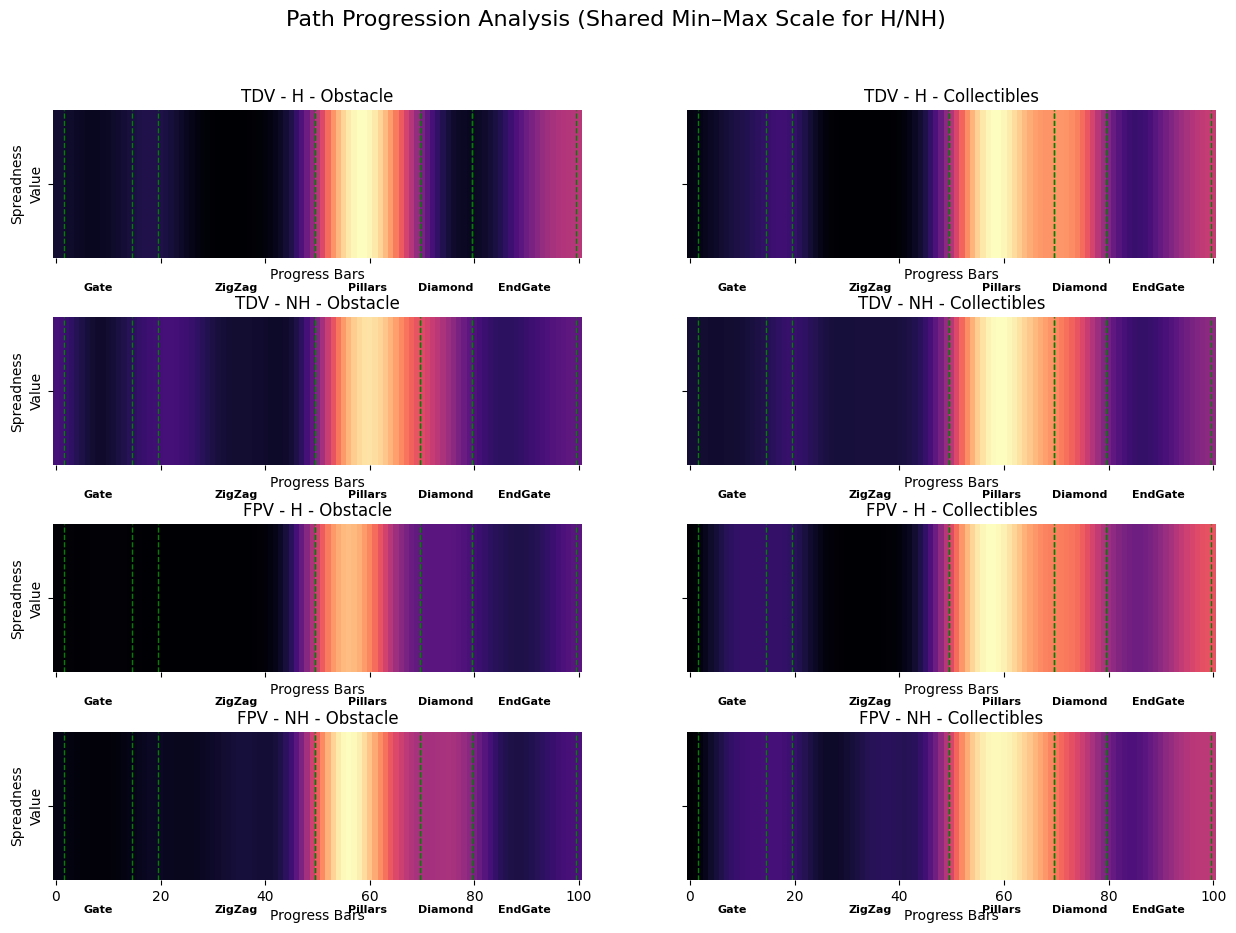

In [172]:
plot_spreadness_path_analysis_minmax(dfTrajectory)

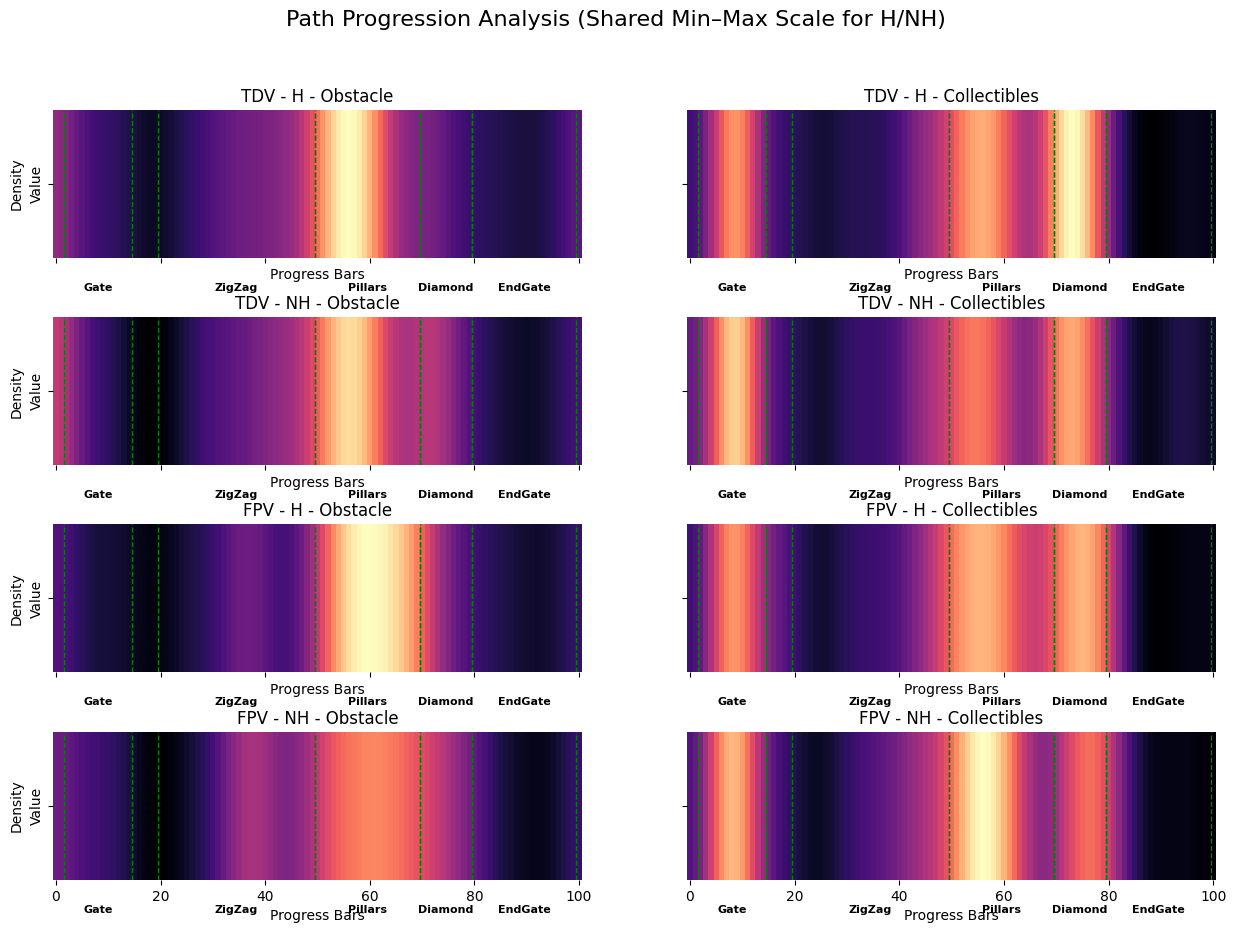

In [173]:
plot_path_analysis_minmax(dfTrajectory)

### detail by portion

In [174]:
def get_summary(dfFold):
    dfFold["General"] = None
    for index, df in dfFold.iterrows():
        allTimes = df["Study"]["ProgressPortion"].value_counts().sort_index()*df["Study"]["Time"].diff().mean()
        allSpreadness = df["Study"][[ "ProgressPortion", "desiredSeparation"]].groupby("ProgressPortion").mean()

        if not df["Crash"].empty:
            allCrash = df["Crash"]["ProgressPortion"].value_counts().sort_index()
        else:
            # Create a Series of zeros, using the same index as allTimes
            allCrash = pd.Series(0, index=allTimes.index)
            

        allCrash = allCrash.reindex(allTimes.index).fillna(0)
        allTimes = allTimes.reindex(allTimes.index).fillna(0)
        allSpreadness = allSpreadness.reindex(allTimes.index).fillna(0)

        dfGeneral = pd.DataFrame({"Crash": allCrash, "Time": allTimes, "Spreadness": allSpreadness["desiredSeparation"]})


        dfFold.at[index, "General"] = dfGeneral

get_summary(dfFolders)

In [112]:
def expand_rows(row):

    subdf = row["General"].copy()
    # Bring the group info into columns
    subdf["Obstacle"] = row["Obstacle"]
    subdf["View"]     = row["View"]
    subdf["Haptics"]  = row["Haptics"]
    return subdf

df_expanded = pd.concat(dfFolders.apply(expand_rows, axis=1).to_list())

df_expanded = df_expanded.reset_index().rename(columns={"index":"ProgressPortion"})


df_final = (
    df_expanded
    .groupby(["Obstacle", "View", "Haptics", "ProgressPortion"], as_index=False)
    .mean(numeric_only=True)
)


In [120]:
#rename EndGate to Gate
df_expanded["Obstacle"] = df_expanded["Obstacle"].replace("EndGate", "Gate")

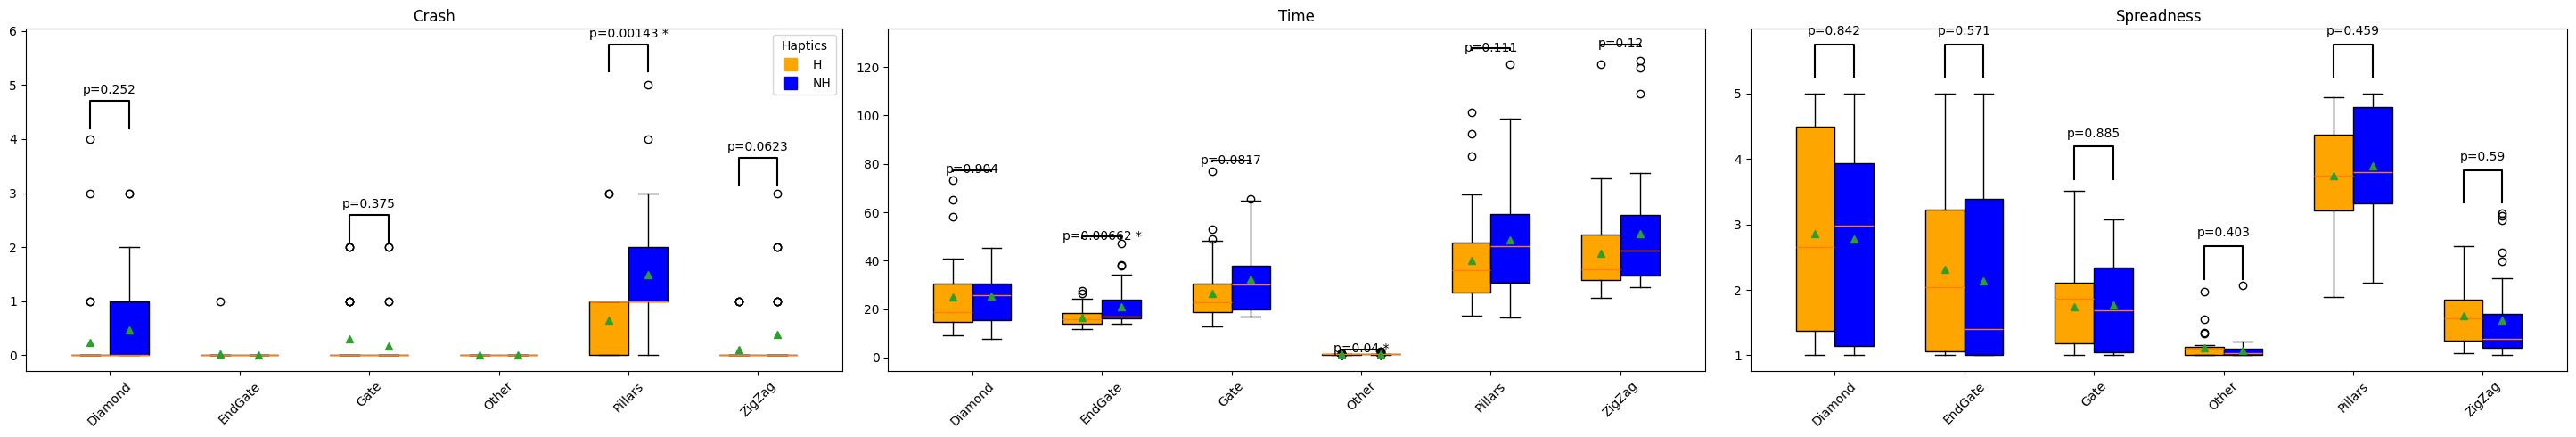

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D

# -----------------------------------------------------------------------------
# 1) Filter df_final for the relevant obstacle & view
#    (Adjust as needed; or remove this if you already have exactly what you want in df_final)
# -----------------------------------------------------------------------------
dfPlot = df_expanded.query("Obstacle == 'Collectibles' and View == 'FPV'")

# The measures we want to plot
measures = ["Crash", "Time", "Spreadness"]

# For controlling the order of "ProgressPortion" on the x-axis
progress_order = sorted(dfPlot["ProgressPortion"].unique())

# Colors for H vs. NH
color_map = {"H": "orange", "NH": "blue"}
haptics_order = ["H", "NH"]

# -----------------------------------------------------------------------------
# 2) Create one subplot per measure so each has its own scale
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=len(measures), figsize=(29, 5), sharey=False)

width = 0.3

# We'll iterate over measures and their corresponding subplot (axis)
for ax, measure in zip(axes, measures):
    
    boxes_data = []
    positions = []
    colors = []
    group_centers = []

    # Loop through each ProgressPortion to build data for boxplots
    for p_idx, pp in enumerate(progress_order):
        
        # Grab the data for H and NH
        subset_H = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "H")][measure]
        subset_NH = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "NH")][measure]
        
        # We'll position these side-by-side:
        # x_base is the integer index for each progress portion
        x_base = p_idx
        
        # Left offset for H
        x_h = x_base - width/2
        boxes_data.append(subset_H)
        positions.append(x_h)
        colors.append(color_map["H"])
        
        # Right offset for NH
        x_nh = x_base + width/2
        boxes_data.append(subset_NH)
        positions.append(x_nh)
        colors.append(color_map["NH"])
        
        group_centers.append(x_base)
    
    # Generate the boxplots for this measure
    bp = ax.boxplot(
        boxes_data,
        positions=positions,
        widths=width,
        patch_artist=True,
        showmeans=True
    )
    
    # Color the boxes: H = orange, NH = blue
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
    
    # Ticks & Labels
    ax.set_xticks(group_centers)
    ax.set_xticklabels(progress_order, rotation=45)
    ax.set_title(measure)
    
    # -----------------------------------------------------------------------------
    # 3) Add p-value brackets for H vs. NH (skip if insufficient data)
    # -----------------------------------------------------------------------------
    for p_idx, pp in enumerate(progress_order):
        subset_H = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "H")][measure]
        subset_NH = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "NH")][measure]
        
        # Check data length
        if (len(subset_H) < 2) or (len(subset_NH) < 2):
            continue  # skip if there's fewer than 2 data points in either group
        
        # Check variance
        if (subset_H.var(ddof=1) == 0) or (subset_NH.var(ddof=1) == 0):
            continue  # skip if zero variance in either group
        
        # Perform t-test
        stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
        
        x1 = p_idx - width/2
        x2 = p_idx + width/2
        
        # We'll place the bracket just above the max of both groups
        y_max = max(subset_H.max(), subset_NH.max())
        # Increase a bit above that max
        line_height = y_max + 0.05 * abs(y_max)  # scale offset by y_max
        
        # Draw the bracket
        ax.plot(
            [x1, x1, x2, x2],
            [line_height, line_height+0.5, line_height+0.5, line_height],
            lw=1.5, c='black'
        )
        
        # Create the p-value text
        p_text = f"p={p_val:.3g}"
        if p_val < 0.001:
            p_text += " **"
        elif p_val < 0.05:
            p_text += " *"
        
        ax.text(
            (x1 + x2)/2,
            line_height+ 0.7,  # slight offset above the bracket
            p_text,
            ha='center', va='center', color='black'
        )

# -----------------------------------------------------------------------------
# 4) Shared legend
#    We'll add it to the first axis or outside the subplots
# -----------------------------------------------------------------------------aa
legend_elems = [
    Line2D([0], [0], color='orange', marker='s', markersize=10, label='H', linewidth=0),
    Line2D([0], [0], color='blue',   marker='s', markersize=10, label='NH', linewidth=0),
]
axes[0].legend(handles=legend_elems, title="Haptics")

plt.tight_layout()
plt.show()


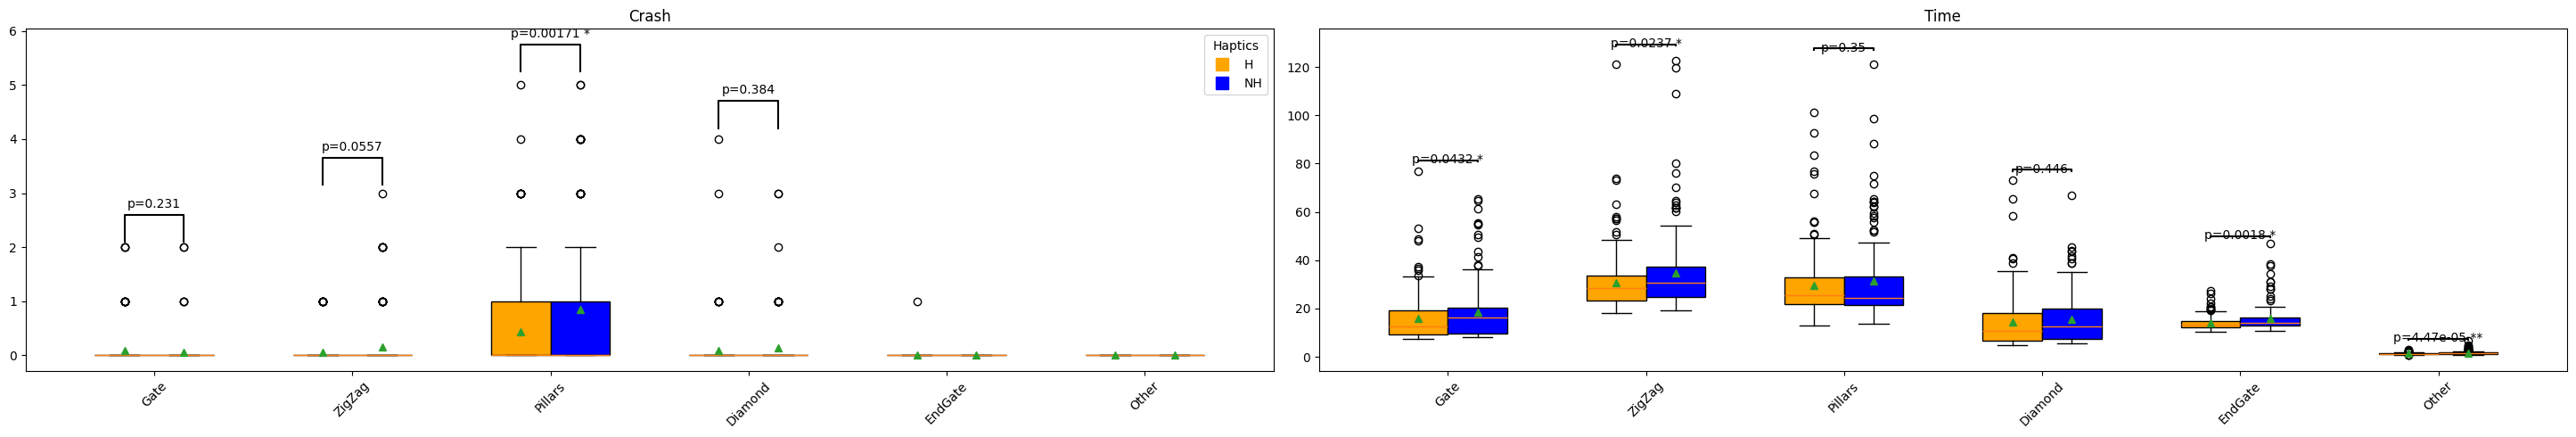

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D

# -----------------------------------------------------------------------------
# 1) Filter df_final for the relevant obstacle & view
#    (Adjust as needed; or remove this if you already have exactly what you want in df_final)
# -----------------------------------------------------------------------------
dfPlot = df_expanded

# The measures we want to plot
measures = ["Crash", "Time"]

obstacle_order = list(obstacles_map.keys())
obstacle_order.append("Other")

progress_order = obstacle_order

color_map = {"H": "orange", "NH": "blue"}
haptics_order = ["H", "NH"]

# -----------------------------------------------------------------------------
# 2) Create one subplot per measure so each has its own scale
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=len(measures), figsize=(29, 5), sharey=False)
width = 0.3

# We'll iterate over measures and their corresponding subplot (axis)
for ax, measure in zip(axes, measures):
    
    boxes_data = []
    positions = []
    colors = []
    group_centers = []

    # Loop through each ProgressPortion to build data for boxplots
    for p_idx, pp in enumerate(progress_order):
        
        # Grab the data for H and NH
        subset_H = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "H")][measure]
        subset_NH = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "NH")][measure]
        
        # We'll position these side-by-side:
        # x_base is the integer index for each progress portion
        x_base = p_idx
        
        # Left offset for H
        x_h = x_base - width/2
        boxes_data.append(subset_H)
        positions.append(x_h)
        colors.append(color_map["H"])
        
        # Right offset for NH
        x_nh = x_base + width/2
        boxes_data.append(subset_NH)
        positions.append(x_nh)
        colors.append(color_map["NH"])
        
        group_centers.append(x_base)
    
    # Generate the boxplots for this measure
    bp = ax.boxplot(
        boxes_data,
        positions=positions,
        widths=width,
        patch_artist=True,
        showmeans=True
    )
    
    # Color the boxes: H = orange, NH = blue
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)
    
    # Ticks & Labels
    ax.set_xticks(group_centers)
    ax.set_xticklabels(progress_order, rotation=45)
    ax.set_title(measure)
    
    # -----------------------------------------------------------------------------
    # 3) Add p-value brackets for H vs. NH (skip if insufficient data)
    # -----------------------------------------------------------------------------
    for p_idx, pp in enumerate(progress_order):
        subset_H = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "H")][measure]
        subset_NH = dfPlot[(dfPlot["ProgressPortion"] == pp) & (dfPlot["Haptics"] == "NH")][measure]
        
        # Check data length
        if (len(subset_H) < 2) or (len(subset_NH) < 2):
            continue  # skip if there's fewer than 2 data points in either group
        
        # Check variance
        if (subset_H.var(ddof=1) == 0) or (subset_NH.var(ddof=1) == 0):
            continue  # skip if zero variance in either group
        
        # Perform t-test
        stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
        
        x1 = p_idx - width/2
        x2 = p_idx + width/2
        
        # We'll place the bracket just above the max of both groups
        y_max = max(subset_H.max(), subset_NH.max())
        # Increase a bit above that max
        line_height = y_max + 0.05 * abs(y_max)  # scale offset by y_max
        
        # Draw the bracket
        ax.plot(
            [x1, x1, x2, x2],
            [line_height, line_height+0.5, line_height+0.5, line_height],
            lw=1.5, c='black'
        )
        
        # Create the p-value text
        p_text = f"p={p_val:.3g}"
        if p_val < 0.001:
            p_text += " **"
        elif p_val < 0.05:
            p_text += " *"
        
        ax.text(
            (x1 + x2)/2,
            line_height+ 0.7,  # slight offset above the bracket
            p_text,
            ha='center', va='center', color='black'
        )

# -----------------------------------------------------------------------------
# 4) Shared legend
#    We'll add it to the first axis or outside the subplots
# -----------------------------------------------------------------------------aa
legend_elems = [
    Line2D([0], [0], color='orange', marker='s', markersize=10, label='H', linewidth=0),
    Line2D([0], [0], color='blue',   marker='s', markersize=10, label='NH', linewidth=0),
]
axes[0].legend(handles=legend_elems, title="Haptics")

plt.tight_layout()
plt.show()


In [129]:
#rename endgate to gate
df_expanded['ProgressPortion'] = df_expanded['ProgressPortion'].replace('EndGate', 'Gate')

#remove other
df_expanded = df_expanded[df_expanded['ProgressPortion'] != 'Other']

p-value for Time at Diamond for TDV-Collectibles: 0.139
p-value for Time at Diamond for TDV-Obstacle: 0.020
p-value for Time at Diamond for FPV-Collectibles: 0.904
p-value for Time at Diamond for FPV-Obstacle: 0.142
p-value for Time at Gate for TDV-Collectibles: 0.016
p-value for Time at Gate for TDV-Obstacle: 0.080
p-value for Time at Gate for FPV-Collectibles: 0.013
p-value for Time at Gate for FPV-Obstacle: 0.045
p-value for Time at Pillars for TDV-Collectibles: 0.186
p-value for Time at Pillars for TDV-Obstacle: 0.061
p-value for Time at Pillars for FPV-Collectibles: 0.111
p-value for Time at Pillars for FPV-Obstacle: 0.554
p-value for Time at ZigZag for TDV-Collectibles: 0.257
p-value for Time at ZigZag for TDV-Obstacle: 0.105
p-value for Time at ZigZag for FPV-Collectibles: 0.120
p-value for Time at ZigZag for FPV-Obstacle: 0.029


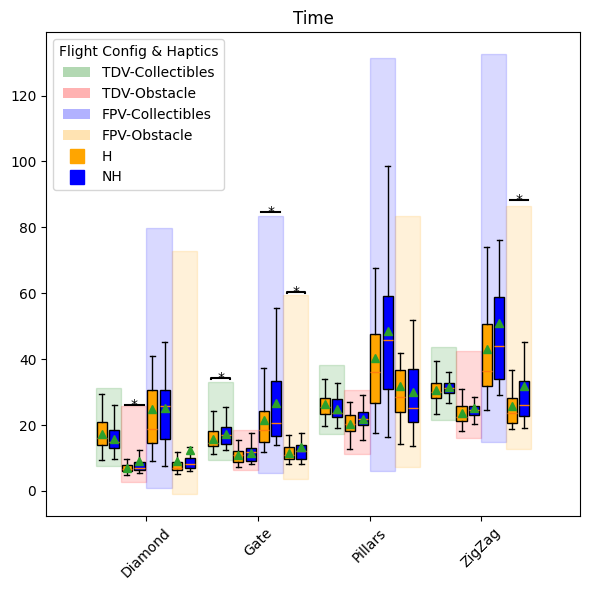

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import ttest_ind

# ------------------------------------------------------------------------------ 
# Example input: dfPlot with columns:
#   ["ProgressPortion", "Crash", "Time", "Spreadness", "Obstacle", "View", "Haptics"]
# ------------------------------------------------------------------------------

vars = ["Time"]
df_melted = df_expanded.melt(
    id_vars=["ProgressPortion", "Obstacle", "View", "Haptics"],
    value_vars=vars,
    var_name="Measure",
    value_name="Score"
)

# 2) Create a new column for flight configuration
df_melted["Configuration"] = df_melted["View"] + "-" + df_melted["Obstacle"]

# 3) Define the orders and color mappings
config_order = ["TDV-Collectibles", "TDV-Obstacle", "FPV-Collectibles", "FPV-Obstacle"]
config_color_map = {
    "TDV-Collectibles": "green",
    "TDV-Obstacle":    "red",
    "FPV-Collectibles": "blue",
    "FPV-Obstacle":    "orange"
}
# Boxes should be colored by haptics (orange or blue)
haptics_color_map = {"H": "orange", "NH": "blue"}

progress_order = sorted(df_melted["ProgressPortion"].unique())
haptics_order = ["H", "NH"]
measures = vars  # e.g. ["Crash", "Time", "Spreadness"]

# 4) Create subplots: one per measure
n_measures = len(measures)
fig, axes = plt.subplots(nrows=1, ncols=n_measures, figsize=(6*n_measures, 6), sharey=False)

# --- Wrap axes in a list if there is only one measure ---
if n_measures == 1:
    axes = [axes]

spacing = 1.0     # horizontal spacing between the 4 configuration clusters
sub_offset = 0.15 # offset for H vs. NH within a config cluster
box_width = 0.9 / len(config_order)  # width of each box
margin_x = 0.05   # horizontal margin for the transparent rectangle

# We'll loop over each measure and create the corresponding subplot
for ax, measure in zip(axes, measures):
    # Prepare data structures for the boxplot
    boxes_data = []
    positions = []
    box_colors = []

    # For storing rectangle geometry and p-value annotations
    rect_info = []    # Each item: (x_left, width_rect, y_bottom, height_rect, facecolor)
    pvalue_info = []  # Each item: (x_left_box, x_right_box, stars, y_max)

    # Loop over each progress portion (the main grouping on x-axis)
    for p_idx, prog in enumerate(progress_order):
        # For each configuration
        for cfg_idx, cfg in enumerate(config_order):

            config_center = p_idx + cfg_idx*box_width - (1-0.9)/2 - 0.2

            # Extract data for H and NH
            subset_H = df_melted[
                (df_melted["Measure"] == measure) &
                (df_melted["ProgressPortion"] == prog) &
                (df_melted["Configuration"] == cfg) &
                (df_melted["Haptics"] == "H")
            ]["Score"]
            subset_NH = df_melted[
                (df_melted["Measure"] == measure) &
                (df_melted["ProgressPortion"] == prog) &
                (df_melted["Configuration"] == cfg) &
                (df_melted["Haptics"] == "NH")
            ]["Score"]

            # Append the two subgroups (H then NH) to the boxplot data
            for h, subset in zip(haptics_order, [subset_H, subset_NH]):
                x_pos = (
                    config_center - box_width/1.5
                    if h == "H"
                    else config_center - box_width/1.5 + box_width/2
                )
                boxes_data.append(subset)
                positions.append(x_pos)
                box_colors.append(haptics_color_map[h])  # color depends on H or NH

            # Determine the vertical extent for the rectangle
            valid_data = pd.concat([subset_H, subset_NH])  # combine them
            if not valid_data.empty:
                y_min = valid_data.min()
                y_max = valid_data.max()
                # Add a small margin top and bottom
                margin_y = 0.1 * (y_max - y_min) if (y_max != y_min) else 0.1
                y_bottom = y_min - margin_y
                height_rect = (y_max - y_min) + 2 * margin_y

                # The rectangle encloses both H and NH boxes horizontally
                x_left_rect = config_center - sub_offset - margin_x
                width_rect = spacing / len(config_order)
                rect_info.append(
                    (
                        x_left_rect,
                        width_rect * 0.9,
                        y_bottom,
                        height_rect,
                        config_color_map[cfg]
                    )
                )

            # --- T-test for H vs. NH (only if p<0.05 do we draw a bracket) ---
            if len(subset_H) >= 2 and len(subset_NH) >= 2:
                if subset_H.var(ddof=1) != 0 and subset_NH.var(ddof=1) != 0:
                    stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
                    print(f"p-value for {measure} at {prog} for {cfg}: {p_val:.3f}")
                    if p_val <= 0.06:
                        # We'll show just stars
                        stars = "**" if p_val < 0.001 else "*"
                        x_left_box = config_center - box_width / 4 - box_width / 2
                        x_right_box = config_center + box_width / 4 - box_width / 4
                        # Place the bracket above the maximum of these two groups
                        group_max = valid_data.max()
                        pvalue_info.append((x_left_box, x_right_box, stars, group_max))

    # --- Now create the boxplots ---
    bp = ax.boxplot(
        boxes_data,
        positions=positions,
        widths=box_width / 2.5,
        patch_artist=True,
        showmeans=True,
        showfliers=False
    )

    # Color each box by the assigned color (orange or blue)
    for patch, col in zip(bp["boxes"], box_colors):
        patch.set_facecolor(col)

    # --- Draw the transparent rectangles for each config group ---
    # We'll put them behind the boxes (zorder=0)
    for (x_left, width_rect, y_bottom, height_rect, facecolor) in rect_info:
        rect = Rectangle(
            (x_left, y_bottom), width_rect, height_rect,
            facecolor=facecolor, edgecolor=facecolor, alpha=0.15, zorder=0
        )
        ax.add_patch(rect)

    # --- Add the p-value brackets with stars ---
    for (x_left_box, x_right_box, stars, group_max) in pvalue_info:
        y_bracket = group_max + 0.1 * abs(group_max) if group_max != 0 else 0.1
        # Draw bracket
        ax.plot(
            [x_left_box, x_left_box, x_right_box, x_right_box],
            [y_bracket, y_bracket + 0.05, y_bracket + 0.05, y_bracket],
            lw=1.5, c='black'
        )
        # Place the stars
        ax.text(
            (x_left_box + x_right_box)/2, y_bracket + 0.07,
            stars, ha='center', va='center', color='black'
        )

    # --- X-axis ticks: one per progress portion ---
    tick_positions = [i for i in range(len(progress_order))]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([str(p) for p in progress_order], rotation=45)
    ax.set_title(measure)

# ------------------------------------------------------------------------------ 
# 6) Create legends
# ------------------------------------------------------------------------------ 
legend_configs = [
    Patch(facecolor=config_color_map[cfg], alpha=0.3, label=cfg)
    for cfg in config_order
]

legend_haptics = [
    Line2D([0], [0], color=haptics_color_map["H"], marker='s', markersize=10,
           label='H', linewidth=0),
    Line2D([0], [0], color=haptics_color_map["NH"], marker='s', markersize=10,
           label='NH', linewidth=0),
]

axes[0].legend(
    handles=legend_configs + legend_haptics,
    title="Flight Config & Haptics", loc='upper left'
)

plt.tight_layout()
plt.show()


In [ ]:
def compute_pvals(subdf):
    """
    For each (Obstacle, View) subset, extract the H vs NH data
    and run a t-test on FinalTime, NumberOfCrash, and isolationTime.
    """
    # Separate data for H vs NH
    h_data  = subdf[subdf["Haptics"] == "H"]
    nh_data = subdf[subdf["Haptics"] == "NH"]


    
    # We'll store p-values in a dictionary
    results = {}
    

    metrics = ["Time", "Crash"]
    for metric in metrics:
        if (len(h_data[metric]) > 1) and (len(nh_data[metric]) > 1):
            _, pval = ttest_ind(h_data[metric], nh_data[metric], nan_policy='omit')
        else:
            pval = 1  # Not enough data to test

        results["p_val_" + metric] = pval
        
    return pd.Series(results)

pvals = (
    df_expanded
    .groupby(["Obstacle", "View", "ProgressPortion"])
    .apply(compute_pvals)
)

pvals

C:\Users\Pablo\AppData\Local\Temp\ipykernel_22504\3598216778.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_pvals)


p_val_Time  p_val_Crash
Obstacle     View ProgressPortion                         
Collectibles FPV  Diamond            0.905970     0.251649
                  Gate               0.012180     0.304481
                  Pillars            0.107931     0.000995
                  ZigZag             0.115738     0.052387
             TDV  Diamond            0.140534     0.983707
                  Gate               0.015412     0.085498
                  Pillars            0.186822     0.082944
                  ZigZag             0.257998     0.327973
Obstacle     FPV  Diamond            0.147342     0.283729
                  Gate               0.048364     0.332499
                  Pillars            0.553770     0.170043
                  ZigZag             0.031137     0.203500
             TDV  Diamond            0.013178     0.286446
                  Gate               0.077380          NaN
                  Pillars            0.066214     0.122486
                  ZigZag             0.106575     0.355098

In [43]:

# 1. Extract obstacle order from obstacles_map
obstacle_order = list(obstacles_map.keys())
# add "Other" to the end
obstacle_order.append("Other")

dfP = df_final.copy()

# 2. Convert 'Obstacle' to an ordered categorical
dfP['ProgressPortion'] = pd.Categorical(
    dfP['ProgressPortion'],
    categories=obstacle_order,
    ordered=True
)

dfP.groupby(["Obstacle", "View", "ProgressPortion", "Haptics"]).mean()

Crash       Time  Spreadness
Obstacle     View ProgressPortion Haptics                                 
Collectibles FPV  DoubleGate      H        0.297297  26.676241    1.742031
                                  NH       0.166667  32.056846    1.773161
                  ZigZag          H        0.108108  42.943913    1.607905
                                  NH       0.361111  50.315863    1.509881
                  Pillars         H        0.648649  40.231296    3.743550
                                  NH       1.583333  48.032432    3.818015
                  Diamond         H        0.243243  24.856784    2.854816
                                  NH       0.472222  24.867773    2.689688
                  EndGate         H        0.027027  16.536236    2.315323
                                  NH       0.000000  20.766353    2.078593
                  Other           H        0.000000   1.324821    1.114952
                                  NH       0.000000   1.464768    1.073793
             TDV  DoubleGate      H        0.085714  17.581764    1.807435
                                  NH       0.000000  19.288390    1.676675
                  ZigZag          H        0.028571  30.684280    1.609575
                                  NH       0.000000  31.722954    1.722612
                  Pillars         H        0.028571  26.224066    3.829551
                                  NH       0.166667  25.052971    3.865205
                  Diamond         H        0.028571  17.336807    3.329022
                                  NH       0.027778  15.554074    3.067138
                  EndGate         H        0.000000  14.112073    2.225155
                                  NH       0.000000  15.428153    2.050544
                  Other           H        0.000000   1.352031    1.520836
                                  NH       0.000000   1.558884    1.745064
Obstacle     FPV  DoubleGate      H        0.000000   9.768594    1.034880
                                  NH       0.027027  12.455882    1.035183
                  ZigZag          H        0.085714  25.824449    1.124929
                                  NH       0.216216  31.712520    1.227337
                  Pillars         H        1.057143  31.900887    2.408247
                                  NH       1.540541  29.967421    2.773754
                  Diamond         H        0.085714   8.944460    1.230614
                                  NH       0.027027  12.334384    1.393683
                  EndGate         H        0.000000  13.317819    1.367092
                                  NH       0.000000  14.114814    1.296310
                  Other           H        0.000000   1.370430    1.064235
                                  NH       0.000000   1.774434    1.089869
             TDV  DoubleGate      H        0.000000   9.393406    1.166981
                                  NH       0.000000  10.125266    1.240365
                  ZigZag          H        0.026316  23.637482    1.189551
                                  NH       0.000000  25.138853    1.235521
                  Pillars         H        0.026316  20.199887    2.559938
                                  NH       0.121212  21.748308    2.474829
                  Diamond         H        0.000000   7.019392    1.218422
                                  NH       0.030303   8.941410    1.624748
                  EndGate         H        0.000000  12.200180    1.633964
                                  NH       0.000000  12.756554    1.430536
                  Other           H        0.000000   1.381132    1.408909
                                  NH       0.000000   1.834457    1.746963

### NASA TLX H vs NH 

In [44]:
# make this to int dfFolders[['PhysicalDemanding', 'Hurry', 'Effort','Frustration', 'Success']] and removr Nan
# make this to int dfFolders[['PhysicalDemanding', 'Hurry', 'Effort','Frustration', 'Success']] and removr Nan
dfAnalysis = dfFolders[['Obstacle', 'View', 'Haptics', 'MentalyDemanding', 'PhysicalDemanding', 'Hurry', 'Effort','Frustration', 'Success']].dropna()
dfAnalysis[['MentalyDemanding', 'PhysicalDemanding', 'Hurry', 'Effort','Frustration', 'Success']] = dfAnalysis[['MentalyDemanding', 'PhysicalDemanding', 'Hurry', 'Effort','Frustration', 'Success']].astype(int)

dfAnalysis.groupby(["Obstacle", "View", "Haptics"]).mean()

MentalyDemanding  PhysicalDemanding      Hurry  \
Obstacle     View Haptics                                                   
Collectibles FPV  H               10.108108           3.864865   8.027027   
                  NH              13.000000           7.058824  10.264706   
             TDV  H                6.514286           2.771429   6.571429   
                  NH               9.117647           4.500000   9.147059   
Obstacle     FPV  H                8.457143           3.028571   6.600000   
                  NH              10.918919           3.351351   8.783784   
             TDV  H                5.473684           2.500000   7.236842   
                  NH               7.363636           2.606061   7.818182   

                             Effort  Frustration    Success  
Obstacle     View Haptics                                    
Collectibles FPV  H        8.918919     9.891892   7.405405  
                  NH       9.941176    13.264706  11.441176  
             TDV  H        6.771429     7.114286   4.371429  
                  NH       9.235294    10.617647   6.176471  
Obstacle     FPV  H        8.057143     8.200000   6.800000  
                  NH       9.432432    11.378378   7.756757  
             TDV  H        7.078947     6.578947   4.342105  
                  NH       8.484848     8.454545   6.030303

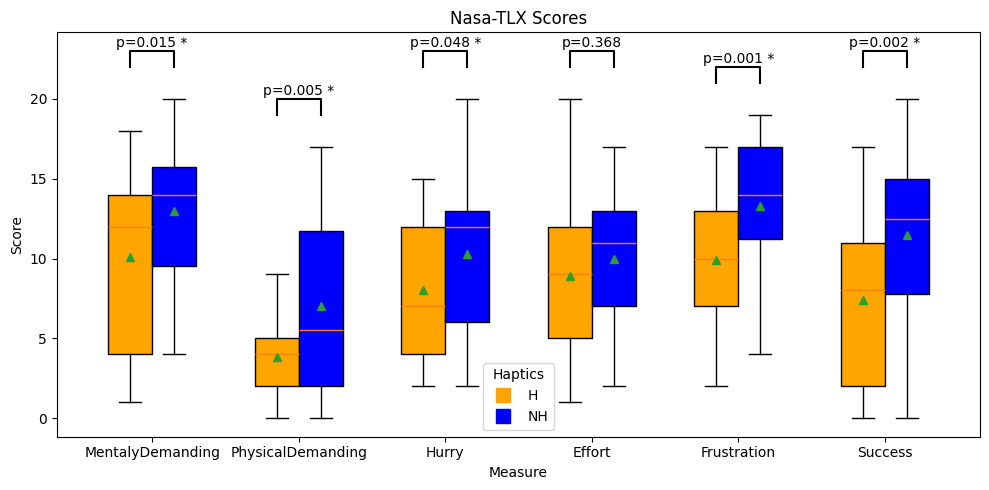

In [45]:
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind

dfPlot = dfAnalysis.query("Obstacle == 'Collectibles' and View == 'FPV'")

df_melted = dfPlot.melt(
    id_vars=["Obstacle","View","Haptics"], 
    value_vars=["MentalyDemanding","PhysicalDemanding","Hurry","Effort","Frustration","Success"],
    var_name="Measure",
    value_name="Score"
)

# We want orange for H, blue for NH
color_map = {"H": "orange", "NH": "blue"}

plt.figure(figsize=(10, 5))

measure_order = ["MentalyDemanding","PhysicalDemanding","Hurry","Effort","Frustration","Success"]
df_melted["Measure"] = pd.Categorical(df_melted["Measure"], categories=measure_order, ordered=True)
unique_measures = df_melted["Measure"].cat.categories

# For convenience, map measure -> integer x index
x_locs = {m: i for i,m in enumerate(unique_measures)}

boxes_data = []
positions = []
colors = []

width = 0.3
for m_idx, m in enumerate(unique_measures):
    for h_idx, haptic_val in enumerate(["H", "NH"]):
        subset = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]==haptic_val)]["Score"]
        boxes_data.append(subset)
        
        offset = -width/2 if haptic_val=="H" else width/2
        positions.append(m_idx + offset)
        
        colors.append(color_map[haptic_val])

bp = plt.boxplot(
    boxes_data, 
    positions=positions, 
    widths=width, 
    patch_artist=True,
    showmeans=True
)

# Color each box
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)

plt.xticks(range(len(unique_measures)), unique_measures, rotation=0)
plt.xlabel("Measure")
plt.ylabel("Score")
plt.title("Nasa-TLX Scores")

legend_elems = [
    Line2D([0],[0], color='orange', marker='s', markersize=10, label='H', linewidth=0),
    Line2D([0],[0], color='blue',   marker='s', markersize=10, label='NH', linewidth=0)
]
plt.legend(handles=legend_elems, title="Haptics")

# --- Now add p-values for H vs. NH per measure ---
ax = plt.gca()

for m_idx, m in enumerate(unique_measures):
    # Grab the data for H vs. NH
    subset_H  = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]=="H")]["Score"]
    subset_NH = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]=="NH")]["Score"]
    
    # Run a simple t-test (or any test of your choice)
    stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
    
    # X positions for the two boxes
    x1 = m_idx - width/2  # H
    x2 = m_idx + width/2  # NH

    # Find a suitable y "height" to place the line above these boxes
    # We can take the max of the two box data and add some offset
    y_max = max(subset_H.max(), subset_NH.max())
    line_height = y_max + 2  # you can tweak this offset
    
    # Draw a line between the two boxes
    ax.plot([x1, x1, x2, x2], 
            [line_height, line_height+1, line_height+1, line_height], 
            lw=1.5, c='black')
    
    # Place the p-value text in the middle and put 1 or 2 stars accoridng to the p-value
    p_text = f"p={p_val:.3f}"
    if p_val < 0.001:
        p_text += " **"
    elif p_val < 0.05:
        p_text += " *"
    
    ax.text((x1+x2)/2, line_height+1.5, p_text, ha='center', va='center', color='black')
    

plt.tight_layout()
plt.show()

p-value for MentalyDemanding at TDV-Collectibles: 0.025
p-value for MentalyDemanding at TDV-Obstacle: 0.079
p-value for MentalyDemanding at FPV-Collectibles: 0.015
p-value for MentalyDemanding at FPV-Obstacle: 0.029
p-value for PhysicalDemanding at TDV-Collectibles: 0.035
p-value for PhysicalDemanding at TDV-Obstacle: 0.887
p-value for PhysicalDemanding at FPV-Collectibles: 0.005
p-value for PhysicalDemanding at FPV-Obstacle: 0.641
p-value for Hurry at TDV-Collectibles: 0.024
p-value for Hurry at TDV-Obstacle: 0.581
p-value for Hurry at FPV-Collectibles: 0.048
p-value for Hurry at FPV-Obstacle: 0.033
p-value for Effort at TDV-Collectibles: 0.042
p-value for Effort at TDV-Obstacle: 0.322
p-value for Effort at FPV-Collectibles: 0.368
p-value for Effort at FPV-Obstacle: 0.233
p-value for Frustration at TDV-Collectibles: 0.002
p-value for Frustration at TDV-Obstacle: 0.082
p-value for Frustration at FPV-Collectibles: 0.001
p-value for Frustration at FPV-Obstacle: 0.004
p-value for Success 

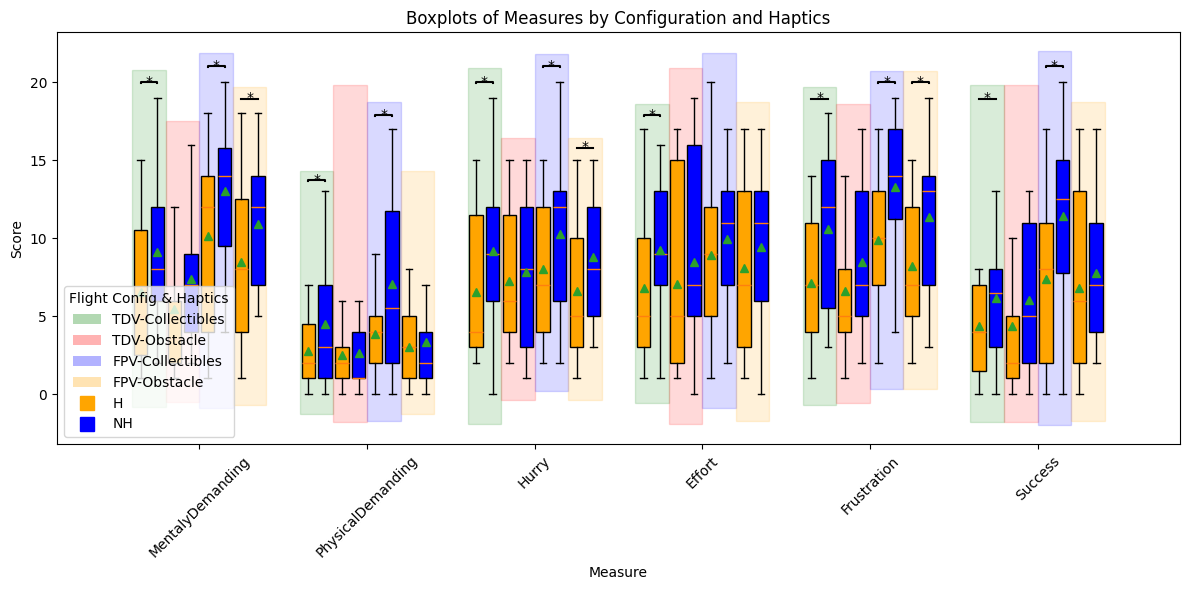

In [151]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
import pandas as pd
from scipy.stats import ttest_ind

# Assume dfAnalysis is your dataframe
measures = ["MentalyDemanding", "PhysicalDemanding", "Hurry", "Effort", "Frustration", "Success"]

# Melt the dataframe so that each measure is in one column
df_melted = dfAnalysis.melt(
    id_vars=["Obstacle", "View", "Haptics"],
    value_vars=measures,
    var_name="Measure",
    value_name="Score"
)

# Create a new Configuration column (combining View and Obstacle)
df_melted["Configuration"] = df_melted["View"] + "-" + df_melted["Obstacle"]

# Define configuration and haptics settings
config_order = ["TDV-Collectibles", "TDV-Obstacle", "FPV-Collectibles", "FPV-Obstacle"]
config_color_map = {
    "TDV-Collectibles": "green",
    "TDV-Obstacle":    "red",
    "FPV-Collectibles": "blue",
    "FPV-Obstacle":    "orange"
}
haptics_order = ["H", "NH"]
haptics_color_map = {"H": "orange", "NH": "blue"}

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Parameters for grouping boxes within each measure (x-axis category)
n_configs = len(config_order)
n_haptics = len(haptics_order)
n_boxes_per_measure = n_configs * n_haptics
group_width = 0.8         # total width allocated to boxes for each measure group
box_width = group_width / n_boxes_per_measure

boxes_data = []  # data for each boxplot
positions = []   # x positions for each box
box_colors = []  # color for each box based on Haptics
pvalue_info = [] # to store p-value bracket info: (x_left, x_right, stars, y_max)

# We'll also store rectangle information for each configuration within each measure
rect_info = []   # Each item: (x_left, width, y_bottom, height, facecolor)

# Loop over each measure group (x-axis category)
for measure_idx, measure in enumerate(measures):
    base_x = measure_idx  # center position for this measure group
    
    # For each configuration within the measure, compute rectangle info first
    for cfg_idx, cfg in enumerate(config_order):
        # Get all data for this measure and configuration (both haptics)
        valid_data = df_melted[
            (df_melted["Measure"] == measure) &
            (df_melted["Configuration"] == cfg)
        ]["Score"]
        if valid_data.empty:
            continue
        y_min = valid_data.min()
        y_max = valid_data.max()
        margin_y = 0.1 * (y_max - y_min) if y_max != y_min else 0.1
        y_bottom = y_min - margin_y
        height_rect = (y_max - y_min) + 2 * margin_y

        # Compute horizontal position for the pair of boxes for this configuration
        # Boxes for this configuration: indices: cfg_idx*n_haptics and cfg_idx*n_haptics+1.
        # We'll add a small margin on the left/right.
        margin_x = box_width * 0.1
        x_left_box = base_x - group_width/2 + (cfg_idx * n_haptics + 0.5) * box_width - (box_width * 0.8)/2
        x_right_box = base_x - group_width/2 + (cfg_idx * n_haptics + 1.5) * box_width + (box_width * 0.8)/2
        x_left_rect = x_left_box - margin_x
        width_rect = (x_right_box - x_left_box) + 2 * margin_x
        
        rect_info.append((x_left_rect, width_rect, y_bottom, height_rect, config_color_map[cfg]))
    
    # Now loop over configurations and haptics to collect box data and compute t-tests
    for cfg_idx, cfg in enumerate(config_order):
        # Get the data subsets for H and NH for this measure and configuration
        subset_H = df_melted[
            (df_melted["Measure"] == measure) &
            (df_melted["Configuration"] == cfg) &
            (df_melted["Haptics"] == "H")
        ]["Score"]
        subset_NH = df_melted[
            (df_melted["Measure"] == measure) &
            (df_melted["Configuration"] == cfg) &
            (df_melted["Haptics"] == "NH")
        ]["Score"]
        
        # Loop over each haptics subgroup
        for h_idx, h in enumerate(haptics_order):
            j = cfg_idx * n_haptics + h_idx
            x_pos = base_x - group_width/2 + (j + 0.5) * box_width
            subset = subset_H if h == "H" else subset_NH
            boxes_data.append(subset)
            positions.append(x_pos)
            box_colors.append(haptics_color_map[h])
        
        # Perform t-test between H and NH (if enough data) and store bracket info if p<=0.06
        if len(subset_H) >= 2 and len(subset_NH) >= 2:
            if subset_H.var(ddof=1) != 0 and subset_NH.var(ddof=1) != 0:
                stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
                print(f"p-value for {measure} at {cfg}: {p_val:.3f}")
                if p_val <= 0.06:
                    stars = "**" if p_val < 0.001 else "*"
                    # x positions for the two boxes of this configuration (using centers)
                    x_left = base_x - group_width/2 + (cfg_idx * n_haptics + 0.5) * box_width
                    x_right = base_x - group_width/2 + (cfg_idx * n_haptics + 1.5) * box_width
                    valid_data = pd.concat([subset_H, subset_NH])
                    if not valid_data.empty:
                        y_max_data = valid_data.max()
                        pvalue_info.append((x_left, x_right, stars, y_max_data))

# Draw the transparent rectangles first (so they appear behind the boxes)
for (x_left, width_rect, y_bottom, height_rect, facecolor) in rect_info:
    rect = Rectangle((x_left, y_bottom), width_rect, height_rect,
                     facecolor=facecolor, edgecolor=facecolor, alpha=0.15, zorder=0)
    ax.add_patch(rect)

# Create the boxplots
bp = ax.boxplot(
    boxes_data,
    positions=positions,
    widths=box_width * 0.8,
    patch_artist=True,
    showmeans=True,
    showfliers=False
)

# Color each box based on its haptics (H or NH)
for patch, col in zip(bp["boxes"], box_colors):
    patch.set_facecolor(col)

# Add p-value brackets (if any)
for (x_left_box, x_right_box, stars, group_max) in pvalue_info:
    y_bracket = group_max + 0.05 * abs(group_max) if group_max != 0 else 0.1
    ax.plot([x_left_box, x_left_box, x_right_box, x_right_box],
            [y_bracket, y_bracket + 0.05, y_bracket + 0.05, y_bracket],
            lw=1.5, c='black')
    ax.text((x_left_box + x_right_box) / 2, y_bracket + 0.07,
            stars, ha='center', va='center', color='black')

# Set x-axis ticks to the measure names
ax.set_xticks(range(len(measures)))
ax.set_xticklabels(measures, rotation=45)
ax.set_xlabel("Measure")
ax.set_ylabel("Score")
ax.set_title("Boxplots of Measures by Configuration and Haptics")

# Create a legend for haptics

legend_configs = [
    Patch(facecolor=config_color_map[cfg], alpha=0.3, label=cfg)
    for cfg in config_order
]

legend_haptics = [
    Line2D([0], [0], color=haptics_color_map["H"], marker='s', markersize=10,
           label='H', linewidth=0),
    Line2D([0], [0], color=haptics_color_map["NH"], marker='s', markersize=10,
           label='NH', linewidth=0),
]


# Add the legend to the plot

ax.legend(
    handles=legend_configs + legend_haptics,
    title="Flight Config & Haptics", loc='lower left'
)
plt.tight_layout()
plt.show()


## Analysis H vs NH


### Crash distribution

In [46]:
#- Obstaclle avoidance--> Crash & Leader
dfCheck = dfFolders.query("View == 'FPV'")

In [47]:
allLayers = []

for index, row in dfCheck.iterrows():
    
    if row["Crash"].empty:
        continue
    allLayers.append(row["Crash"]["layer"].values)


In [48]:
dfTrajectory["numberOfCrashLayer1"] = 0
dfTrajectory["numberOfCrashOther"] = 0
dfTrajectory["ProportionCrashLeader"] = 0
dfTrajectory["NuberCrash"] = 0

for index, row in dfTrajectory.iterrows():
    if row["Crash"].empty:
        continue
    dfTrajectory.at[index, "numberOfCrashLayer1"] = len(row["Crash"].query("layer == 1"))
    dfTrajectory.at[index, "numberOfCrashOther"] = len(row["Crash"].query("layer != 1"))
    dfTrajectory.at[index, "NuberCrash"] = len(row["Crash"])
    if(len(row["Crash"]) > 0):
        dfTrajectory.at[index, "ProportionCrashLeader"] = float(dfTrajectory.at[index, "numberOfCrashLayer1"] / len(row["Crash"]))
    else:
        dfTrajectory.at[index, "ProportionCrashLeader"] = 0


    

In [49]:
dfTrajectory.query("View == 'FPV'")[[ "Haptics", "ProportionCrashLeader", "NuberCrash"]].groupby(["Haptics"]).mean()

,ProportionCrashLeader,NuberCrash
Haptics,,
H,0.580921,46.0
NH,0.625903,80.0


In [50]:
dfFolders["NumberOfCrash"] = 0
dfFolders["ProportionCrashesLayer1"] = np.nan

for index, row in dfFolders.iterrows():
    dfFolders.at[index, "NumberOfCrash"] = len(row["Crash"])
    if(len(row["Crash"]) > 0):
        dfFolders.at[index, "ProportionCrashesLayer1"] = float(len(row["Crash"].query("layer == 1")) / len(row["Crash"]))
    else:
        dfFolders.at[index, "ProportionCrashesLayer1"] = 0

Text(0.5, 1.0, 'Distribution of Crashes by Haptics in FPV (H vs. NH)')

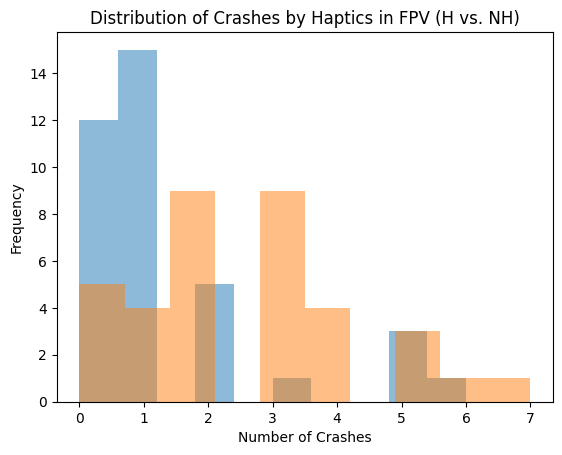

In [51]:
df = dfFolders.query("View == 'FPV' & Obstacle == 'Collectibles'")[["Haptics", "NumberOfCrash"]]

df_h = df[df['Haptics'] == 'H']
df_nh = df[df['Haptics'] == 'NH']

# Plot histograms for each group
plt.hist(df_h['NumberOfCrash'], alpha=0.5, label='H')
plt.hist(df_nh['NumberOfCrash'], alpha=0.5, label='NH')

plt.xlabel('Number of Crashes')
plt.ylabel('Frequency')
plt.title('Distribution of Crashes by Haptics in FPV (H vs. NH)')


t-statistic: -3.407738052908011, p-value: 0.0008559975614283841


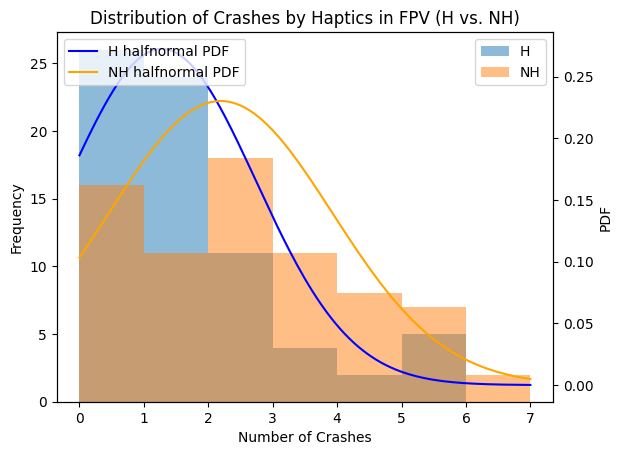

In [52]:

from scipy import stats
 
df = dfFolders.query("View == 'FPV'")[["Haptics", "NumberOfCrash"]]
df = df[df["NumberOfCrash"] < 8]

df_h = df[df['Haptics'] == 'H']['NumberOfCrash']
df_nh = df[df['Haptics'] == 'NH']['NumberOfCrash']
#remove the outliers



# Create figure and axes
fig, ax = plt.subplots()

# Plot histograms on the main axis
ax.hist(df_h, bins='auto', alpha=0.5, label='H')
ax.hist(df_nh, bins='auto', alpha=0.5, label='NH')
ax.set_xlabel('Number of Crashes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Crashes by Haptics in FPV (H vs. NH)')
ax.legend(loc='upper right')



# Generate x-values in [0, max crash count in both sets]

#fit normal distribution
mu_h, std_h = stats.norm.fit(df_h)
mu_nh, std_nh = stats.norm.fit(df_nh)



xmin = 0
xmax = max(df_h.max(), df_nh.max())
x = np.linspace(xmin, xmax, 200)  # for smooth curve


pdf_h = stats.norm.pdf(x, mu_h, std_h)
pdf_nh = stats.norm.pdf(x, mu_nh, std_nh)

# Create a second y-axis for the PDF curves
ax2 = ax.twinx()
ax2.plot(x, pdf_h, color='blue', label='H halfnormal PDF')
ax2.plot(x, pdf_nh, color='orange', label='NH halfnormal PDF')
ax2.set_ylabel('PDF')

# Display legends for the second axis too, if desired
ax2.legend(loc='upper left')

#perform a t-test
t_stat, p_val = stats.ttest_ind(df_h, df_nh, equal_var=False)
print(f"t-statistic: {t_stat}, p-value: {p_val}")



plt.show()

In [53]:
dfFolders["NumberOfCrash"].describe()

count    287.000000
mean       0.947735
std        1.453494
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        7.000000
Name: NumberOfCrash, dtype: float64

### Feedback On Feedback

In [54]:
cols = ['ObstacleAvoidance_Usefulness', 'ObstacleAvoidance_Annoyance','ObstacleAvoidance_Intuitivness', 'ObstacleAvoidance_Precission',
       'Spreadness_Usefulness', 'Spreadness_Annoyance',
       'Spreadness_Intuitivness', 'Spreadness_Precission',
       'Connectivness_Usefulness', 'Connectivness_Annoyance',
       'Connectivness_Intuitivness', 'Connectivness_Precission',
       'Disconnection_Usefulness', 'Disconnection_Annoyance',
       'Disconnection_Intuitivness', 'Disconnection_Precission',
       'TrajPred_Usefulness', 'TrajPred_Annoyance', 'TrajPred_Intuitivness',
       'TrajPred_Precission', 'Crash_Usefulness', 'Crash_Annoyance',
       'Crash_Intuitivness', 'Crash_Precission']

dfPlotQuestionnaire = dfQuestionnaire[cols + ['Haptics']].dropna()

dfPlotQuestionnaire[cols] = dfPlotQuestionnaire[cols].astype(int)

In [55]:
import matplotlib.patches as mpatches
def boxPlot_questionnaire(df):
    categories = [
        'ObstacleAvoidance',
        'Spreadness',
        'Connectivness',
        'Disconnection',
        'TrajPred',
        'Crash'
    ]
    aspects = ['Usefulness', 'Annoyance', 'Intuitivness', 'Precission']

    # Make sure your DataFrame columns are numeric!
    # For safety, convert them:
    for cat in categories:
        for asp in aspects:
            col_name = f"{cat}_{asp}"
            df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

    # 6 distinct colors (one per category)
    colors = [plt.cm.Set2(i) for i in range(len(categories))]

    fig, ax = plt.subplots(figsize=(10, 4))

    # We'll place each “aspect” at x = 1, 2, 3, 4, ...
    # around which we group 6 boxplots (one per category).
    width = 0.12  # horizontal shift between categories within a group

    for j, aspect in enumerate(aspects):
        # Collect data for the 6 categories under this aspect
        data_for_boxplot = []
        positions = []
        
        # j+1 is the “center” of the group for aspect j (so aspect 0 -> x=1, aspect 1 -> x=2, etc.)
        group_center = j + 1
        
        for i, cat in enumerate(categories):
            col_name = f"{cat}_{aspect}"
            # Get the numeric answers for this category+aspect pair
            data = df[col_name].dropna()
            data_for_boxplot.append(data)
            
            # Position of this box = group_center + a small offset based on i
            # This way, the 6 boxes for one aspect are side by side.
            offset = i - (len(categories) - 1) / 2
            x_pos = group_center + offset * width
            positions.append(x_pos)

        # Now plot these 6 boxes at the specified x-positions
        bplot = ax.boxplot(
            data_for_boxplot, positions=positions, widths=width,
            patch_artist=True,   # needed so we can set facecolor
            showfliers=True      # or False if you want to hide outliers
        )

        # Color each box by the category
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

    # Label the x‐axis at x=1,2,3,4 with the aspect names
    ax.set_xticks(range(1, len(aspects) + 1))
    ax.set_xticklabels(aspects)

    ax.set_title("All Aspects on One Plot")

    # Create a legend mapping each category (6 of them) to its color
    legend_patches = [
        mpatches.Patch(color=c, label=cat) for c, cat in zip(colors, categories)
    ]
    ax.legend(handles=legend_patches, title="Categories", loc="best")

    plt.tight_layout()
    plt.show()

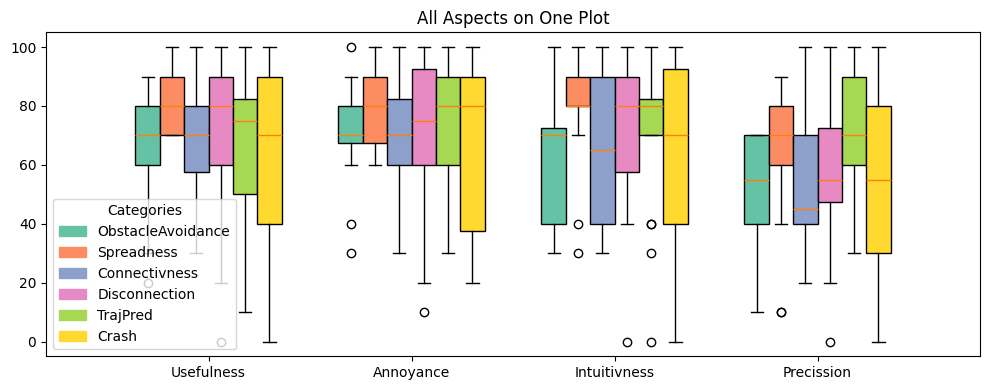

In [56]:
boxPlot_questionnaire(dfPlotQuestionnaire.query("Haptics == 'H'"))

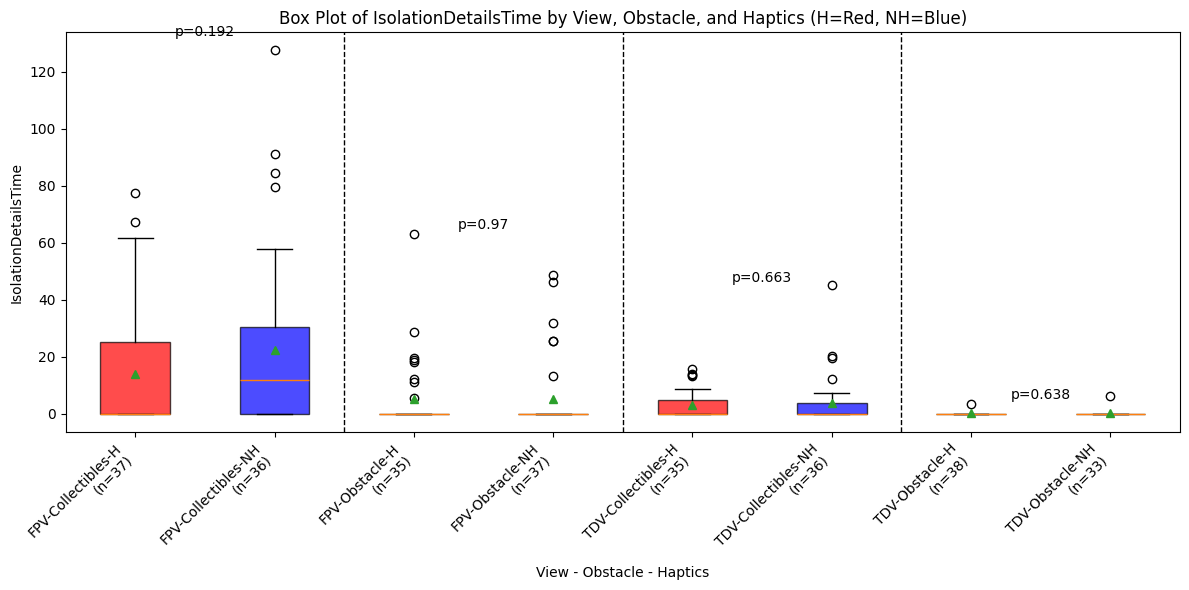

In [57]:
boxPlotSituation(dfFolders, "IsolationDetailsTime")

### ANOVA

In [58]:
dfFolders[['IsolationDetailsNumber', 'IsolationDetailsTime', 'IsolationTimeMean', 'Obstacle', 'View', 'Haptics']].groupby(['Obstacle', 'View', 'Haptics']).mean()

IsolationDetailsNumber  IsolationDetailsTime  \
Obstacle     View Haptics                                                 
Collectibles FPV  H                      1.270270             14.013168   
                  NH                     1.944444             22.390424   
             TDV  H                      1.085714              2.926610   
                  NH                     0.805556              3.656333   
Obstacle     FPV  H                      0.628571              5.041863   
                  NH                     0.459459              5.155101   
             TDV  H                      0.052632              0.088778   
                  NH                     0.060606              0.186571   

                           IsolationTimeMean  
Obstacle     View Haptics                     
Collectibles FPV  H                 4.666335  
                  NH               10.076997  
             TDV  H                 1.157807  
                  NH                2.072357  
Obstacle     FPV  H                 1.813498  
                  NH                2.801563  
             TDV  H                 0.044389  
                  NH                0.139928

In [59]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

factors = ['Obstacle', 'View', 'Haptics']
dependent_vars = ['IsolationDetailsNumber', 'IsolationDetailsTime', 'IsolationTimeMean']

anova_results = {}

for dep_var in dependent_vars:
    # Build the formula string for statsmodels
    formula = f"{dep_var} ~ C(Obstacle) * C(View) * C(Haptics)"

    # Fit the model
    model = ols(formula, data=dfFolders).fit()

    # ANOVA table
    anova_table = sm.stats.anova_lm(model, typ=2)  
    # 'typ=2' or 'typ=3' depends on your preference; typically 'typ=2' or 'typ=3' for unbalanced designs

    # Store or print results
    anova_results[dep_var] = anova_table
    print(f"ANOVA for {dep_var}")
    print(anova_table)
    print("\n" + "-"*40 + "\n")

ANOVA for IsolationDetailsNumber
                                    sum_sq     df          F        PR(>F)
C(Obstacle)                      68.928582    1.0  38.408218  2.055008e-09
C(View)                          23.771603    1.0  13.245955  3.254290e-04
C(Haptics)                        0.273775    1.0   0.152552  6.964063e-01
C(Obstacle):C(View)               0.506969    1.0   0.282492  5.954955e-01
C(Obstacle):C(Haptics)            1.445262    1.0   0.805326  3.702796e-01
C(View):C(Haptics)                2.742192    1.0   1.527997  2.174529e-01
C(Obstacle):C(View):C(Haptics)    5.730861    1.0   3.193336  7.502449e-02
Residual                        500.702075  279.0        NaN           NaN

----------------------------------------

ANOVA for IsolationDetailsTime
                                      sum_sq     df          F        PR(>F)
C(Obstacle)                      4812.480116    1.0  20.160955  1.042911e-05
C(View)                          7105.791367    1.0  29.768339  

## Linear regression

In [60]:
colsQuestionnaire = ['Gender', 'Age', 'PlayVideoGames','PlayVideoGamesWeekly', 'PlayVideoGamesWeeklyHighest','ControlOperated', 'ControlOperatedHours']
dfQu = dfQuestionnaire[colsQuestionnaire+['PID']]

dfFolders[colsQuestionnaire] = np.nan


for index, row in dfQu.iterrows():
    PID = row["PID"]
    dfFolders.loc[dfFolders["PID"] == PID, colsQuestionnaire] = row[colsQuestionnaire].values

colsAnovaVariables = ['Gender', 'Age', 'PlayVideoGames','PlayVideoGamesWeekly', 'PlayVideoGamesWeeklyHighest','ControlOperated', 'ControlOperatedHours', 'Haptics']
colsAnovaTest = ['FinalTime', 'NumberOfCrash', 'isolationTime', 'IsolationTimeMean']

In [61]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway


Abnd = dfFolders

# Suppose your DataFrame is named 'Abnd'

results = []
for factor_col in colsAnovaVariables:
    for test_col in colsAnovaTest:
        # Get the data split by factor_col categories
        groups = []
        for group_level in Abnd[factor_col].dropna().unique():
            data_group = Abnd.loc[Abnd[factor_col] == group_level, test_col].dropna()
            if len(data_group) > 0:
                groups.append(data_group)

        # We need at least 2 groups with data to run ANOVA
        if len(groups) < 2:
            f_val = np.nan
            p_val = np.nan
        else:
            f_val, p_val = f_oneway(*groups)

        results.append({
            'Factor': factor_col,
            'Test Variable': test_col,
            'F-Value': f_val,
            'p-Value': p_val
        })

# Convert the results into a DataFrame for a clean view
anova_results = pd.DataFrame(results)

# Optionally, sort by p-value or F-value
anova_results.sort_values(by="p-Value", inplace=True)


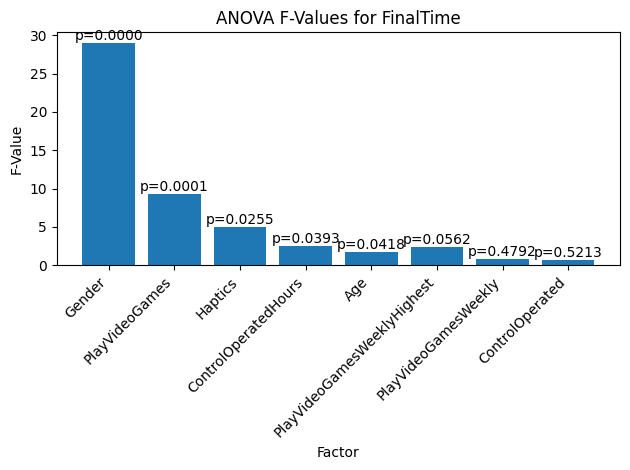

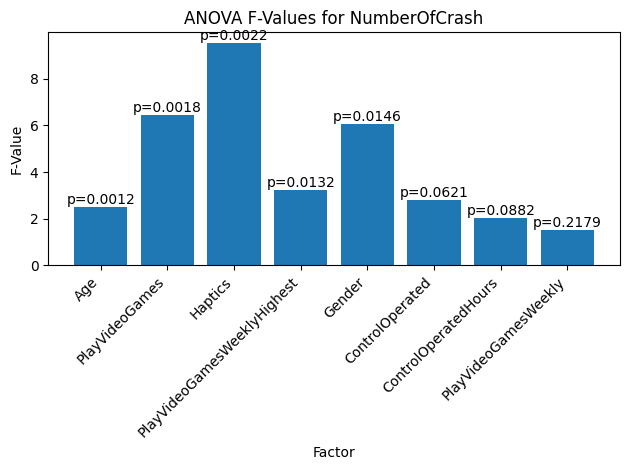

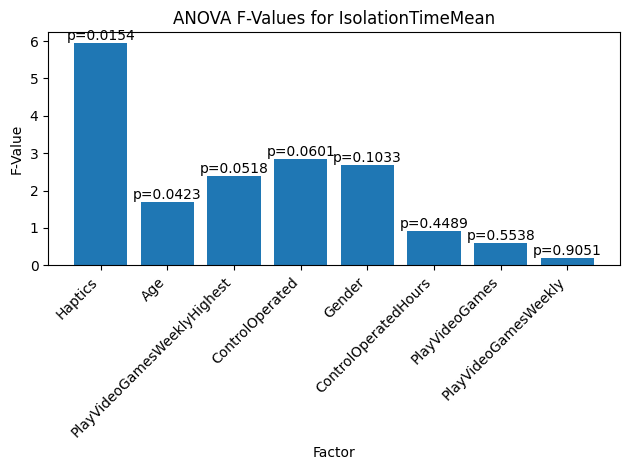

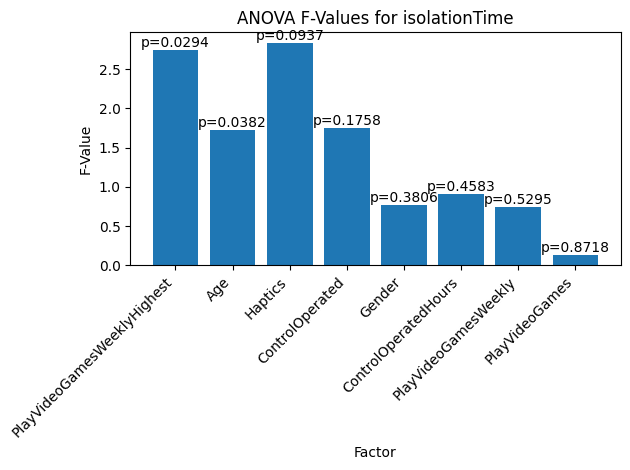

In [62]:

unique_test_vars = anova_results["Test Variable"].unique()
for test_var in unique_test_vars:
    # Filter the rows for this test variable
    subset = anova_results[anova_results["Test Variable"] == test_var]
    
    # Sort subset by F-Value or p-Value if desired (optional)
    # subset = subset.sort_values("F-Value", ascending=False)
    
    # Create a new figure for each test variable (no subplots)
    fig, ax = plt.subplots()

    # X positions for bars
    x_positions = range(len(subset))

    # Plot bar chart of F-Values
    ax.bar(x_positions, subset["F-Value"])

    # Set x-axis labels to the Factor names
    ax.set_xticks(x_positions)
    ax.set_xticklabels(subset["Factor"], rotation=45, ha="right")

    # Labeling
    ax.set_title(f"ANOVA F-Values for {test_var}")
    ax.set_xlabel("Factor")
    ax.set_ylabel("F-Value")

    # Annotate each bar with the p-value
    for i, row in enumerate(subset.itertuples()):
        ax.text(
            i,                               # x position
            row._3,                          # F-Value is in the 3rd column after the index in this tuple
            f"p={row._4:.4f}",               # p-Value is in the 4th column
            ha='center', va='bottom'
        )
    
    plt.tight_layout()
    plt.show()

In [63]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Ensure Age is numeric
Abnd["Age"] = pd.to_numeric(Abnd["Age"], errors="coerce")

# Treat ControlOperatedHours as string (categorical)
Abnd["ControlOperatedHours"] = Abnd["ControlOperatedHours"].astype(str)

# Define your initially desired categorical and numeric columns:
cat_vars_original = [
    'Gender', 
    'PlayVideoGames', 
    'PlayVideoGamesWeekly', 
    'PlayVideoGamesWeeklyHighest', 
    'ControlOperated', 
    'Haptics',
    'ControlOperatedHours'
]
num_vars = ['Age']

colsAnovaTest = ['FinalTime', 'NumberOfCrash', 'isolationTime', 'IsolationTimeMean']

# -- Filter out categorical columns with fewer than 2 unique valid values --
cat_vars_filtered = []
for c in cat_vars_original:
    uniques = Abnd[c].dropna().unique()
    if len(uniques) >= 2:
        cat_vars_filtered.append(c)
    else:
        print(f"Skipping '{c}' because it has {len(uniques)} unique non-null values: {uniques}")

print("\nFinal list of categorical vars used:", cat_vars_filtered)

all_coefs = []
for test_var in colsAnovaTest:
    # Build formula for the current dependent variable
    # e.g. "FinalTime ~ C(Gender) + C(PlayVideoGames) + ... + Age"
    formula_parts = [f"C({c})" for c in cat_vars_filtered] + num_vars
    formula = f"{test_var} ~ " + " + ".join(formula_parts)
    
    # Fit OLS model
    model = smf.ols(formula=formula, data=Abnd).fit()
    
    # Collect coefficient estimates and p-values
    for predictor, coef_val in model.params.items():
        p_val = model.pvalues[predictor]
        all_coefs.append({
            "Test Variable": test_var,
            "Predictor": predictor,
            "Coefficient": coef_val,
            "p-Value": p_val
        })

coef_df = pd.DataFrame(all_coefs)
coef_df = coef_df.sort_values(by="Coefficient")



Final list of categorical vars used: ['Gender', 'PlayVideoGames', 'PlayVideoGamesWeekly', 'PlayVideoGamesWeeklyHighest', 'ControlOperated', 'Haptics', 'ControlOperatedHours']


## Direction of movemernt


In [64]:
df = dfFolders.iloc[0]


def getAngle(row):
    #{'x': 10.316067695617676, 'y': 0.0, 'z': -1.5184365510940552}
    alignement = row["alignment"]
    x = alignement["x"]
    z = alignement["z"]

    camForward = row["cameraForward"]
    x2 = camForward["x"]
    z2 = camForward["z"]

    angle = np.arctan2(z2, x2) - np.arctan2(z, x)
    angle = np.degrees(angle)

    if angle < 0:
        angle = 360 + angle

    return angle

def getDirection(row):
    angle = row["Angle"]
    if angle >= 315 or angle < 45:
        return "N"
    elif angle >= 45 and angle < 135:
        return "E"
    elif angle >= 135 and angle < 225:
        return "S"
    else:
        return "W"
    


for index, row in dfFolders.iterrows():
    print(index, end="\r")
    row["Study"]["Angle"] = row["Study"].apply(getAngle, axis=1)
    row["Study"]["Direction"] = row["Study"].apply(getDirection, axis=1)

    proportionWest = len(row["Study"].query("Direction == 'W'")) / len(row["Study"])
    proportionEast = len(row["Study"].query("Direction == 'E'")) / len(row["Study"])
    proportionNorth = len(row["Study"].query("Direction == 'N'")) / len(row["Study"])
    proportionSouth = len(row["Study"].query("Direction == 'S'")) / len(row["Study"])

    dfFolders.at[index, "ProportionWest"] = proportionWest
    dfFolders.at[index, "ProportionEast"] = proportionEast
    dfFolders.at[index, "ProportionNorth"] = proportionNorth
    dfFolders.at[index, "ProportionSouth"] = proportionSouth
    


In [65]:
dfFolders[['ProportionWest', 'ProportionEast','ProportionNorth', 'ProportionSouth', 'Obstacle', 'View', 'Haptics']].groupby(['Obstacle', 'View', 'Haptics']).describe()

ProportionWest                                \
                                   count      mean       std       min   
Obstacle     View Haptics                                                
Collectibles FPV  H                 37.0  0.109293  0.061686  0.023849   
                  NH                36.0  0.122036  0.034639  0.055673   
             TDV  H                 35.0  0.272069  0.144085  0.025000   
                  NH                36.0  0.278614  0.140761  0.028970   
Obstacle     FPV  H                 35.0  0.076798  0.058014  0.002175   
                  NH                37.0  0.085929  0.066043  0.007979   
             TDV  H                 38.0  0.298881  0.195716  0.013048   
                  NH                33.0  0.199065  0.126147  0.013999   

                                                                   \
                                25%       50%       75%       max   
Obstacle     View Haptics                                           
Collectibles FPV  H        0.077144  0.105002  0.118703  0.415117   
                  NH       0.096142  0.125291  0.142996  0.231333   
             TDV  H        0.119671  0.309275  0.395945  0.455614   
                  NH       0.124316  0.296273  0.395092  0.493211   
Obstacle     FPV  H        0.040547  0.073138  0.090049  0.294152   
                  NH       0.041580  0.069691  0.107849  0.279115   
             TDV  H        0.069292  0.299505  0.485509  0.569464   
                  NH       0.083370  0.230701  0.270144  0.469518   

                          ProportionEast            ... ProportionNorth  \
                                   count      mean  ...             75%   
Obstacle     View Haptics                           ...                   
Collectibles FPV  H                 37.0  0.180076  ...        0.670100   
                  NH                36.0  0.185194  ...        0.643090   
             TDV  H                 35.0  0.144097  ...        0.646944   
                  NH                36.0  0.161017  ...        0.573409   
Obstacle     FPV  H                 35.0  0.132558  ...        0.837105   
                  NH                37.0  0.141941  ...        0.808511   
             TDV  H                 38.0  0.111026  ...        0.718814   
                  NH                33.0  0.150418  ...        0.786000   

                                    ProportionSouth                      \
                                max           count      mean       std   
Obstacle     View Haptics                                                 
Collectibles FPV  H        0.774260            37.0  0.110539  0.052246   
                  NH       0.733035            36.0  0.106852  0.028728   
             TDV  H        0.874895            35.0  0.127749  0.100233   
                  NH       0.796853            36.0  0.109253  0.089883   
Obstacle     FPV  H        0.921153            35.0  0.042516  0.033279   
                  NH       0.920519            37.0  0.051184  0.042998   
             TDV  H        0.899960            38.0  0.096591  0.115975   
                  NH       0.885254            33.0  0.056339  0.105246   

                                                                             
                                min       25%       50%       75%       max  
Obstacle     View Haptics                                                    
Collectibles FPV  H        0.048874  0.077709  0.103315  0.125517  0.334681  
                  NH       0.047473  0.086220  0.109604  0.122974  0.173528  
             TDV  H        0.013598  0.040525  0.095839  0.222090  0.309834  
                  NH       0.019331  0.048658  0.073253  0.132333  0.313593  
Obstacle     FPV  H        0.000000  0.018044  0.036919  0.058686  0.137942  
                  NH       0.000000  0.021984  0.043555  0.065690  0.197309  
             TDV  H        0.000000  0.007640  0.031148  0.201338  0.423819  
                  N

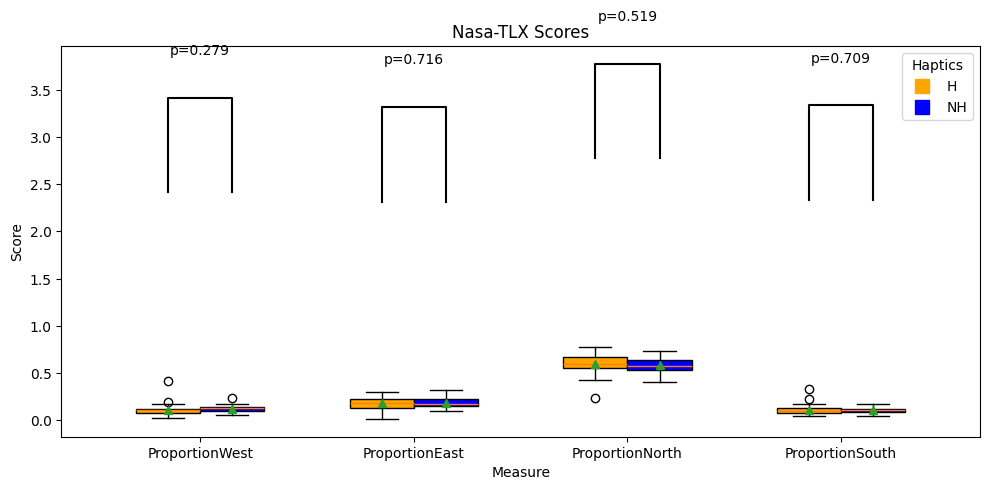

In [66]:

dfPlot = dfFolders.query("Obstacle == 'Collectibles' and View == 'FPV'")

df_melted = dfPlot.melt(
    id_vars = ["Obstacle","View","Haptics"], 
    value_vars = ['ProportionWest', 'ProportionEast','ProportionNorth', 'ProportionSouth'],
    var_name="Measure",
    value_name="Score"
)

# We want orange for H, blue for NH
color_map = {"H": "orange", "NH": "blue"}

plt.figure(figsize=(10, 5))

measure_order = ['ProportionWest', 'ProportionEast','ProportionNorth', 'ProportionSouth']
df_melted["Measure"] = pd.Categorical(df_melted["Measure"], categories=measure_order, ordered=True)
unique_measures = df_melted["Measure"].cat.categories

# For convenience, map measure -> integer x index
x_locs = {m: i for i,m in enumerate(unique_measures)}

boxes_data = []
positions = []
colors = []

width = 0.3
for m_idx, m in enumerate(unique_measures):
    for h_idx, haptic_val in enumerate(["H", "NH"]):
        subset = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]==haptic_val)]["Score"]
        boxes_data.append(subset)
        
        offset = -width/2 if haptic_val=="H" else width/2
        positions.append(m_idx + offset)
        
        colors.append(color_map[haptic_val])

bp = plt.boxplot(
    boxes_data, 
    positions=positions, 
    widths=width, 
    patch_artist=True,
    showmeans=True
)

# Color each box
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)

plt.xticks(range(len(unique_measures)), unique_measures, rotation=0)
plt.xlabel("Measure")
plt.ylabel("Score")
plt.title("Nasa-TLX Scores")

legend_elems = [
    Line2D([0],[0], color='orange', marker='s', markersize=10, label='H', linewidth=0),
    Line2D([0],[0], color='blue',   marker='s', markersize=10, label='NH', linewidth=0)
]
plt.legend(handles=legend_elems, title="Haptics")

# --- Now add p-values for H vs. NH per measure ---
ax = plt.gca()

for m_idx, m in enumerate(unique_measures):
    # Grab the data for H vs. NH
    subset_H  = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]=="H")]["Score"]
    subset_NH = df_melted[(df_melted["Measure"]==m) & (df_melted["Haptics"]=="NH")]["Score"]
    
    # Run a simple t-test (or any test of your choice)
    stat, p_val = ttest_ind(subset_H, subset_NH, equal_var=False)
    
    # X positions for the two boxes
    x1 = m_idx - width/2  # H
    x2 = m_idx + width/2  # NH

    # Find a suitable y "height" to place the line above these boxes
    # We can take the max of the two box data and add some offset
    y_max = max(subset_H.max(), subset_NH.max())
    line_height = y_max + 2  # you can tweak this offset
    
    # Draw a line between the two boxes
    ax.plot([x1, x1, x2, x2], 
            [line_height, line_height+1, line_height+1, line_height], 
            lw=1.5, c='black')
    
    # Place the p-value text in the middle and put 1 or 2 stars accoridng to the p-value
    p_text = f"p={p_val:.3f}"
    if p_val < 0.001:
        p_text += " **"
    elif p_val < 0.05:
        p_text += " *"
    
    ax.text((x1+x2)/2, line_height+1.5, p_text, ha='center', va='center', color='black')
    

plt.tight_layout()
plt.show()

In [67]:
dfFolders.query("Obstacle == 'Collectibles' and View == 'FPV'")[['ProportionWest', 'ProportionEast','ProportionNorth', 'ProportionSouth','Haptics']].groupby(['Haptics']).mean()

,ProportionWest,ProportionEast,ProportionNorth,ProportionSouth
Haptics,,,,
H,0.109293,0.180076,0.600091,0.110539
NH,0.122036,0.185194,0.585918,0.106852


In [68]:
for i, df in dfFolders.iterrows():
    print(i)
    df["Crash"]["Direction"] = None
    for index, row in df["Crash"].iterrows():
        time = row["Time"]
        #find the closest time in the Study
        closest_time = df["Study"]["Time"].sub(time).abs().idxmin()
        #get the direction
        direction = df["Study"].loc[closest_time]["Direction"]
        df["Crash"].at[index, "Direction"] = direction
        df["Crash"].at[index, "isLeader"] = row["layer"] == 1

6
7
14
15
22
23
30
31
38
39
46
47
54
55
62
70
71
78
79
87
94
95
102
103
110
111
118
126
127
134
142
143
150
151
158
159
166
167
174
175
182
183
190
191
198
206
207
214
215
223
231
238
239
246
247
254
255
263
270
271
278
279
286
287
294
295
302
303
310
311
318
2
3
10
11
18
19
26
27
34
35
42
43
50
51
58
59
67
74
75
82
83
90
91
98
99
106
107
122
123
130
131
138
146
147
154
155
162
163
170
171
178
179
186
187
194
195
202
203
210
211
218
226
227
234
235
242
243
250
251
258
259
266
267
274
275
282
283
299
306
307
314
315
4
12
13
20
21
28
29
36
37
44
52
53
60
61
68
69
76
77
84
92
93
101
108
109
124
125
132
133
140
141
148
149
156
157
164
165
172
173
181
188
189
196
204
205
212
213
220
221
228
229
236
237
244
245
252
253
260
261
268
269
276
277
284
285
292
293
300
301
309
316
317
0
1
8
9
16
17
24
25
33
41
48
56
57
64
65
72
73
80
88
89
96
97
104
105
120
121
128
129
136
137
144
145
152
153
160
161
168
169
176
177
184
185
192
193
200
201
208
209
216
217
224
225
232
233
240
241
248
249
256
257
264

In [69]:
dfCrash = pd.DataFrame()

for i, df in dfFolders.iterrows():
    newdf = df["Crash"].copy()
    newdf["Obstacle"] = df["Obstacle"]
    newdf["View"] = df["View"]
    newdf["Haptics"] = df["Haptics"]
    newdf["ProportionWest"] = df["ProportionWest"]

    dfCrash = pd.concat([dfCrash, newdf])

    


In [70]:
dfCrash.query("isLeader == 1 & View == 'FPV' & Obstacle == 'Collectibles'")[["Direction", "Haptics"]].groupby("Haptics")

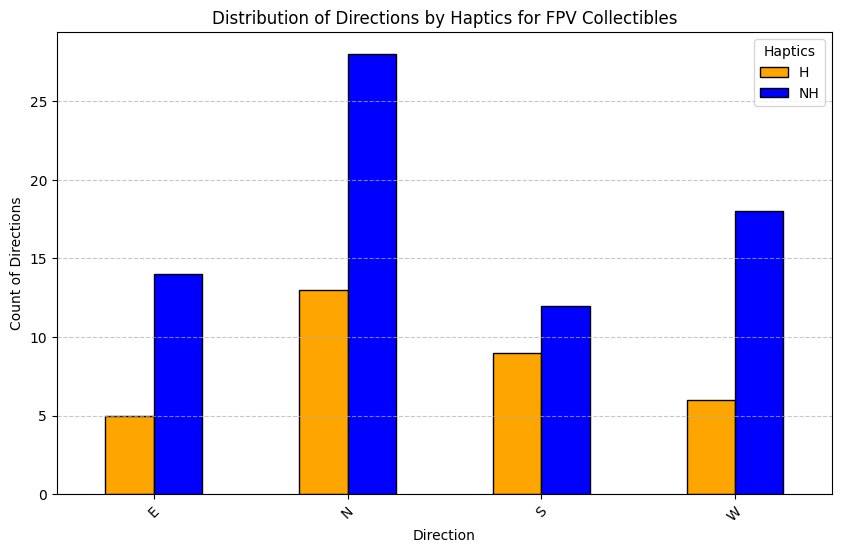

In [71]:

# Filter the DataFrame
filtered_df = dfCrash.query("isLeader == 1 & View == 'FPV' & Obstacle == 'Collectibles'")[["Direction", "Haptics"]]

# Group by Direction first, then Haptics, and get the counts
grouped_data = filtered_df.groupby(["Direction", "Haptics"]).size().unstack(fill_value=0)

# Ensure columns are in the order [NH, Haptic] so colors map correctly
# (Adjust the column names below if your original strings differ, e.g. 'NH' vs. 'NoHaptics')
ordered_cols = ['H', 'NH']
grouped_data = grouped_data.reindex(columns=ordered_cols)

# Plot side-by-side bars:
#   - We have as many groups on the x-axis as unique Directions
#   - Within each group, two bars: NH (blue), Haptic (orange)
grouped_data.plot(
    kind='bar',
    figsize=(10,6),
    color=['orange','blue'],  # NH = Blue, Haptic = Orange
    edgecolor='black'
)

plt.title("Distribution of Directions by Haptics for FPV Collectibles")
plt.xlabel("Direction")
plt.ylabel("Count of Directions")
plt.xticks(rotation=45)
plt.legend(title="Haptics")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## TDV vs FPV

In [80]:
cols = ['FinalTime','NumberOfCrash', 'isolationTime','MentalyDemanding', 'PhysicalDemanding', 'Hurry','Effort', 'Frustration', 'Success']

#drop the Nan values of dfFolders

dfFolders = dfFolders.dropna(subset=cols)

#make the columns to int
dfFolders[cols] = dfFolders[cols].astype(int)

#group by Obstacle, View, Haptics and get the mean
dfFolders[cols +["Obstacle", "View", "Haptics"]].groupby(["Obstacle", "View", "Haptics"]).mean()

FinalTime  NumberOfCrash  isolationTime  \
Obstacle     View Haptics                                             
Collectibles FPV  H        152.081081       1.324324            0.0   
                  NH       179.411765       2.529412            0.0   
             TDV  H        106.771429       0.171429            0.0   
                  NH       108.000000       0.176471            0.0   
Obstacle     FPV  H         90.600000       1.228571            0.0   
                  NH       101.891892       1.810811            0.0   
             TDV  H         73.315789       0.052632            0.0   
                  NH        79.969697       0.151515            0.0   

                           MentalyDemanding  PhysicalDemanding      Hurry  \
Obstacle     View Haptics                                                   
Collectibles FPV  H               10.108108           3.864865   8.027027   
                  NH              13.000000           7.058824  10.264706   
             TDV  H                6.514286           2.771429   6.571429   
                  NH               9.117647           4.500000   9.147059   
Obstacle     FPV  H                8.457143           3.028571   6.600000   
                  NH              10.918919           3.351351   8.783784   
             TDV  H                5.473684           2.500000   7.236842   
                  NH               7.363636           2.606061   7.818182   

                             Effort  Frustration    Success  
Obstacle     View Haptics                                    
Collectibles FPV  H        8.918919     9.891892   7.405405  
                  NH       9.941176    13.264706  11.441176  
             TDV  H        6.771429     7.114286   4.371429  
                  NH       9.235294    10.617647   6.176471  
Obstacle     FPV  H        8.057143     8.200000   6.800000  
                  NH       9.432432    11.378378   7.756757  
             TDV  H        7.078947     6.578947   4.342105  
                  NH       8.484848     8.454545   6.030303

### TDV FPV NASA TLX

MentalyDemanding FPVC-FPVOb 0.034145625345311195
MentalyDemanding FPVC-TDVC 2.2341694935557604e-05
MentalyDemanding FPVOb-TDVOb 2.9025233117490566e-05
MentalyDemanding FPVC-TDVOb 3.048138116114703e-09
MentalyDemanding FPVOb-TDVC 0.01909626114308755
PhysicalDemanding FPVC-FPVOb 0.0010761061398613914
PhysicalDemanding FPVC-TDVC 0.011329352034481375
PhysicalDemanding FPVC-TDVOb 4.1406838559654105e-05
Hurry FPVC-TDVOb 0.03897121254793433
Frustration FPVC-FPVOb 0.03141892087820208
Frustration FPVC-TDVC 0.0007716788882995123
Frustration FPVOb-TDVOb 0.0025338810632456158
Frustration FPVC-TDVOb 2.8949927490367585e-07
Success FPVC-FPVOb 0.020570086502931573
Success FPVC-TDVC 1.390720033245112e-06
Success FPVOb-TDVOb 0.009055489234328066
Success FPVC-TDVOb 5.455584129638416e-06
Success FPVOb-TDVC 0.005673646559874432


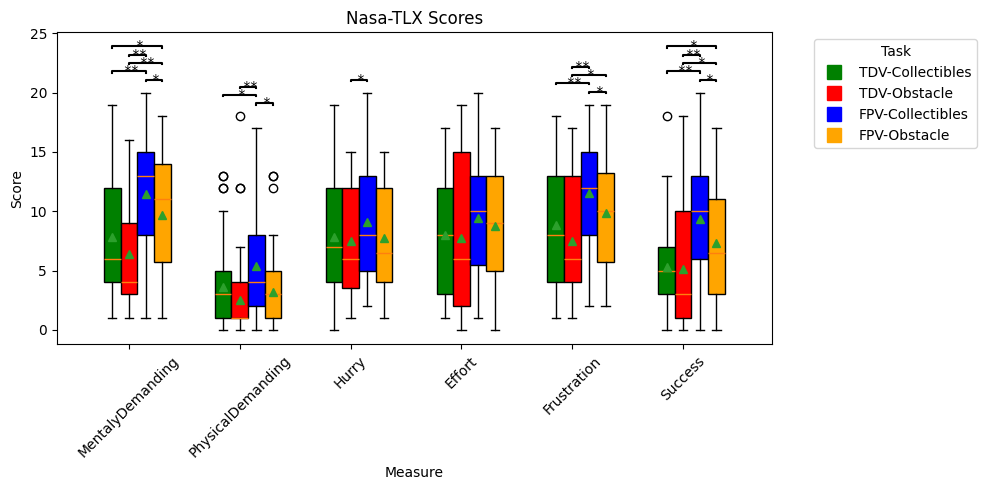

In [81]:
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind

dfPlot = dfFolders

df_melted = dfPlot.melt(
    id_vars=["Obstacle","View"], 
    value_vars=["MentalyDemanding","PhysicalDemanding","Hurry","Effort","Frustration","Success"],
    var_name="Measure",
    value_name="Score"
)

# We want orange for H, blue for NH
color_map =    {"TDV-Collectibles": "green",
                "TDV-Obstacle" : "red",
                "FPV-Collectibles": "blue",
                "FPV-Obstacle": "orange"}

plt.figure(figsize=(10, 5))

measure_order = ["MentalyDemanding","PhysicalDemanding","Hurry","Effort","Frustration","Success"]
df_melted["Measure"] = pd.Categorical(df_melted["Measure"], categories=measure_order, ordered=True)
unique_measures = df_melted["Measure"].cat.categories

# For convenience, map measure -> integer x index
x_locs = {m: i for i,m in enumerate(unique_measures)}

boxes_data = []
positions = []
colors = []

width = 0.6
for m_idx, m in enumerate(unique_measures):
    delta = 0
    for view in ["TDV", "FPV"]:
        for obstacle in ["Collectibles", "Obstacle"]:
            delta += 1
            subset = df_melted[(df_melted["Measure"]==m) & (df_melted["Obstacle"]==obstacle) & (df_melted["View"]==view)]["Score"]
            boxes_data.append(subset)
            
            offset = delta * width/4
            positions.append(m_idx + offset - width/2)

            colors.append(color_map[f"{view}-{obstacle}"])

bp = plt.boxplot(
    boxes_data, 
    positions=positions, 
    widths=width/4, 
    patch_artist=True,
    showmeans=True
)

# Color each box
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)

plt.xticks(range(len(unique_measures)), unique_measures, rotation=45)
plt.xlabel("Measure")
plt.ylabel("Score")
plt.title("Nasa-TLX Scores")

legend_elems = [
    Line2D([0],[0], color='green', marker='s', markersize=10, label='TDV-Collectibles', linewidth=0),
    Line2D([0],[0], color='red',   marker='s', markersize=10, label='TDV-Obstacle', linewidth=0),
    Line2D([0],[0], color='blue', marker='s', markersize=10, label='FPV-Collectibles', linewidth=0),
    Line2D([0],[0], color='orange',   marker='s', markersize=10, label='FPV-Obstacle', linewidth=0)
]
plt.legend(handles=legend_elems, title="Task", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Now add p-values for H vs. NH per measure ---
ax = plt.gca()
smallLine = 0.1
deltaBetween = 0.6


for m_idx, m in enumerate(unique_measures):
    # Grab the data for FPV-Collectibles vs FPV-Obstacle vs TDV-Collectibles vs TDV-Obstacle
    subset_FPVC  = df_melted[(df_melted["Measure"]==m) & (df_melted["Obstacle"]=="Collectibles") & (df_melted["View"]=="FPV")]["Score"]
    subset_FPVOb = df_melted[(df_melted["Measure"]==m) & (df_melted["Obstacle"]=="Obstacle") & (df_melted["View"]=="FPV")]["Score"]
    subset_TDVC  = df_melted[(df_melted["Measure"]==m) & (df_melted["Obstacle"]=="Collectibles") & (df_melted["View"]=="TDV")]["Score"]
    subset_TDVOb = df_melted[(df_melted["Measure"]==m) & (df_melted["Obstacle"]=="Obstacle") & (df_melted["View"]=="TDV")]["Score"]

    # Run a simple t-test (or any test of your choice)
    stat, p_val_FPVC_FPVOb = ttest_ind(subset_FPVC, subset_FPVOb, equal_var=False)
    stat, p_val_TDVC_TDVOb = ttest_ind(subset_TDVC, subset_TDVOb, equal_var=False)
    stat, p_val_FPVC_TDVC = ttest_ind(subset_FPVC, subset_TDVC, equal_var=False)
    stat, p_val_FPVOb_TDVOb = ttest_ind(subset_FPVOb, subset_TDVOb, equal_var=False)
    stat, p_val_FPVC_TDVOb = ttest_ind(subset_FPVC, subset_TDVOb, equal_var=False)
    stat, p_val_FPVOb_TDVC = ttest_ind(subset_FPVOb, subset_TDVC, equal_var=False)


    # X positions for the boxes
    x3 = m_idx - width/4  # FPV-Collectibles
    x4 = m_idx      # FPV-Obstacle
    x1 = m_idx + width/4 # TDV-Collectibles
    x2 = m_idx + width/2 # TDV-Obstacle

    allPValues = [p_val_FPVC_FPVOb, p_val_TDVC_TDVOb, p_val_FPVC_TDVC, p_val_FPVOb_TDVOb, p_val_FPVC_TDVOb, p_val_FPVOb_TDVC]
    names = ["FPVC-FPVOb", "TDVC-TDVOb", "FPVC-TDVC", "FPVOb-TDVOb", "FPVC-TDVOb", "FPVOb-TDVC"]
    positions = [[x1, x2], [x3, x4], [x1, x3], [x2, x4], [x1, x4], [x2, x3]]

    # Find a suitable y "height" to place the line above these boxes
    # We can take the max of the two box data and add some offset
    y_max = max(subset_FPVC.max(), subset_FPVOb.max(), subset_TDVC.max(), subset_TDVOb.max())
    line_height = y_max + 1  # you can tweak this offset


    for i, p in enumerate(allPValues):
        if p > 0.05:
            continue
        
        print(m, names[i], allPValues[i])
        x1 = positions[i][0]
        x2 = positions[i][1]


        # Draw a line between the two boxes
        ax.plot([x1, x1, x2, x2], 
                [line_height, line_height+smallLine, line_height+smallLine, line_height], 
                lw=1.5, c='black')
        
        # Place the p-value text in the middle and put 1 or 2 stars accoridng to the p-value
        p_text = ""
        if p < 0.001:
            p_text += " **"
        elif p < 0.05:
            p_text += " *"

        
        ax.text((x1+x2)/2, line_height+0.1, p_text, ha='center', va='center', color='black')
        line_height += deltaBetween + smallLine
    

plt.tight_layout()
plt.show()

In [82]:
dfQuestionnaire = pd.read_pickle("dfQuestionnaire.pkl")

In [84]:
dfPref = dfQuestionnaire["TDVvsFPV"].value_counts()

<Axes: xlabel='TDVvsFPV'>

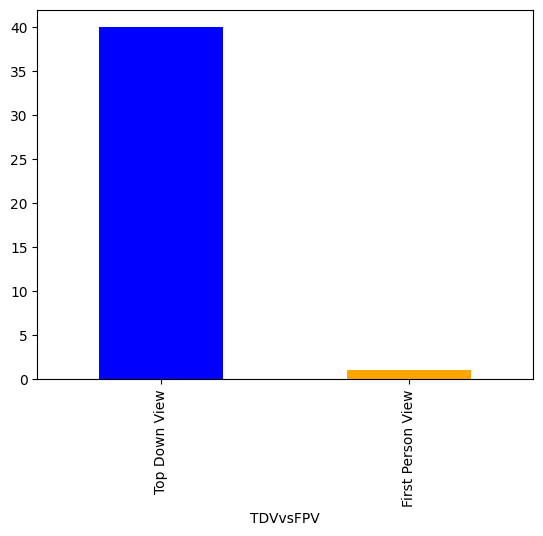

In [85]:
dfPref.plot(kind='bar', color=['blue', 'orange'])

In [135]:
dfFolders.columns

Index(['PID', 'Run', 'Obstacle', 'View', 'Haptics', 'Order', 'Date', 'File',
       'Crash', 'Study', 'Stars', 'SwarmState', 'Constants', 'FinalTime',
       'NumberOfCrash', 'isolationTime', 'leaderPercentage',
       'meanDiffPosition', 'MentalyDemanding', 'PhysicalDemanding', 'Hurry',
       'Effort', 'Frustration', 'Success', 'IsolationDetails',
       'IsolationDetailsNumber', 'IsolationDetailsTime', 'IsolationTimeMean',
       'leaderPercentageSelected', 'meanDiffPositionSelected', 'General',
       'ProportionCrashesLayer1', 'Gender', 'Age', 'PlayVideoGames',
       'PlayVideoGamesWeekly', 'PlayVideoGamesWeeklyHighest',
       'ControlOperated', 'ControlOperatedHours', 'ProportionWest',
       'ProportionEast', 'ProportionNorth', 'ProportionSouth'],
      dtype='object')

In [136]:
dfFolders[["Obstacle", "View", "Haptics", "NumberOfCrash"]].groupby(["Obstacle", "View", "Haptics"]).mean()

NumberOfCrash
Obstacle     View Haptics               
Collectibles FPV  H             1.516129
                  NH            2.606061
             TDV  H             0.100000
                  NH            0.187500
Obstacle     FPV  H             1.344828
                  NH            1.636364
             TDV  H             0.031250
                  NH            0.133333

In [90]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# --- 1) Compute mean and std grouped by (Obstacle, View, Haptics) ---
metrics = ["FinalTime", "NumberOfCrash", "IsolationTimeMean"]
grouped_stats = (
    dfFolders
    .groupby(["Obstacle", "View"])[metrics]
    .agg(["mean", "std"])
)

# Flatten multi-level column names (("FinalTime","mean") -> "FinalTime_mean")
grouped_stats.columns = [
    f"{col1}_{col2}" for col1, col2 in grouped_stats.columns
]

# --- 2) Compute p-values comparing H vs NH for each (Obstacle, View) pair ---
def compute_pvals(subdf):
    """
    For each (Obstacle, View) subset, extract the H vs NH data
    and run a t-test on FinalTime, NumberOfCrash, and isolationTime.
    """
    # Separate data for H vs NH
    h_data  = subdf[subdf["View"] == "FPV"]
    nh_data = subdf[subdf["View"] == "TDV"]

    # Convert columns to float as necessary
    h_data["FinalTime"] = h_data["FinalTime"].astype(float)
    nh_data["FinalTime"] = nh_data["FinalTime"].astype(float)
    
    # Debug info (optional)
    print(
        "for", subdf["Obstacle"].iloc[0], 
        subdf["View"].iloc[0], 
        "H =", len(h_data), 
        "NH =", len(nh_data),
        "NaNs in H =", h_data["FinalTime"].isna().sum(),
        "NaNs in NH =", nh_data["FinalTime"].isna().sum()
    )
    
    results = {}
    
    # Metrics to test

    for metric in metrics:
        # Only run t-test if at least 2 data points in each group
        if len(h_data[metric]) > 1 and len(nh_data[metric]) > 1:
            _, pval = ttest_ind(h_data[metric], nh_data[metric], nan_policy='omit')
            print(
                f"Computing p-value for {metric}:",
                f"H mean={h_data[metric].mean():.2f}, NH mean={nh_data[metric].mean():.2f},",
                f"H std={h_data[metric].std():.2f}, NH std={nh_data[metric].std():.2f},",
                f"p-value={pval:.4f}"
            )
        else:
            print("Not enough data for", metric, "(skipping t-test)")
            pval = np.nan
        # Store in results dict as p_val_<metric>
        results["p_val_" + metric] = pval
        
    return pd.Series(results)

# Run t-test for each (Obstacle, View) pair and get p-values
pvals = (
    dfFolders
    .groupby("Obstacle")
    .apply(compute_pvals)
)

# --- 3) Join p-values with the grouped statistics ---
final_df = grouped_stats.join(
    pvals,
    on=['Obstacle'],  # match only Obstacle & View
    how='left'
)

# Reorder columns explicitly so p-values match the correct metrics
final_df = final_df[
    [
        metrics[0]+"_mean",
        metrics[0]+"_std",
        metrics[1]+"_mean",
        metrics[1]+"_std",
        metrics[2]+"_mean",
        metrics[2]+"_std",
        "p_val_"+metrics[0],
        "p_val_"+metrics[1],
        "p_val_"+metrics[2],
    ]
]

# For clarity, rename columns to a simpler form (optional)
final_df.columns = [
    "FinalTime_mean", 
    "FinalTime_std", 
    "NumberOfCrash_mean", 
    "NumberOfCrash_std",
    "isolationTime_mean", 
    "isolationTime_std",
    "p_val_FinalTime", 
    "p_val_NumberOfCrash", 
    "p_val_isolationTime",
]

df = final_df.copy()

# --- 4) Create a pretty table with significance info ---
def get_significance_stars(p):
    """Return a string of asterisks based on p-value thresholds."""
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

pretty_data = []

# df has a multi-index of (Obstacle, View, Haptics)
for idx, row in df.iterrows():
    # Unpack row data
    final_mean = row["FinalTime_mean"]
    final_std  = row["FinalTime_std"]
    final_p    = row["p_val_FinalTime"]
    
    crash_mean = row["NumberOfCrash_mean"]
    crash_std  = row["NumberOfCrash_std"]
    crash_p    = row["p_val_NumberOfCrash"]

    iso_mean = row["isolationTime_mean"]
    iso_std  = row["isolationTime_std"]
    iso_p    = row["p_val_isolationTime"]

    # If p-value is NaN, set to 1.0 (no significance)
    if np.isnan(final_p):
        final_p = 1.0
    if np.isnan(crash_p):
        crash_p = 1.0
    if np.isnan(iso_p):
        iso_p = 1.0

    # Create the text with mean ± std, attach significance stars
    final_str = f"{final_mean:.2f} ± {final_std:.2f} {get_significance_stars(final_p)} (p={final_p:.3f})"
    crash_str = f"{crash_mean:.2f} ± {crash_std:.2f} {get_significance_stars(crash_p)} (p={crash_p:.3f})"
    iso_str   = f"{iso_mean:.2f} ± {iso_std:.2f} {get_significance_stars(iso_p)} (p={iso_p:.3f})"
    
    # Retrieve index values
    obstacle, haptics = idx

    # Store this row in a list
    pretty_data.append([
        obstacle,
        view,
        final_str,
        crash_str,
        iso_str
    ])

pretty_columns = [
    "Obstacle",
    "View",
    "FinalTime (mean ± std)",
    "NumberOfCrash (mean ± std)",
    "isolationTime (mean ± std)",
]

pretty_df = pd.DataFrame(pretty_data, columns=pretty_columns)
pretty_df.set_index(["Obstacle", "View"], inplace=True)

# 'pretty_df' now has the correctly aligned p-values in each metric's column.
pretty_df


for Collectibles TDV H = 71 NH = 69 NaNs in H = 0 NaNs in NH = 0
Computing p-value for FinalTime: H mean=165.17, NH mean=107.38, H std=52.61, NH std=11.31, p-value=0.0000
Computing p-value for NumberOfCrash: H mean=1.90, NH mean=0.17, H std=1.77, NH std=0.38, p-value=0.0000
Computing p-value for IsolationTimeMean: H mean=7.54, NH mean=1.34, H std=10.34, NH std=2.55, p-value=0.0000
for Obstacle TDV H = 72 NH = 71 NaNs in H = 0 NaNs in NH = 0
Computing p-value for FinalTime: H mean=96.40, NH mean=76.41, H std=26.75, NH std=9.41, p-value=0.0000
Computing p-value for NumberOfCrash: H mean=1.53, NH mean=0.10, H std=1.57, NH std=0.30, p-value=0.0000
Computing p-value for IsolationTimeMean: H mean=2.32, NH mean=0.09, H std=5.77, NH std=0.58, p-value=0.0015


C:\Users\Pablo\AppData\Local\Temp\ipykernel_22504\1332894963.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_pvals)


FinalTime (mean ± std) NumberOfCrash (mean ± std)  \
Obstacle     View                                                            
Collectibles TDV   165.17 ± 52.61 *** (p=0.000)  1.90 ± 1.77 *** (p=0.000)   
             TDV   107.38 ± 11.31 *** (p=0.000)  0.17 ± 0.38 *** (p=0.000)   
Obstacle     TDV    96.40 ± 26.75 *** (p=0.000)  1.53 ± 1.57 *** (p=0.000)   
             TDV     76.41 ± 9.41 *** (p=0.000)  0.10 ± 0.30 *** (p=0.000)   

                   isolationTime (mean ± std)  
Obstacle     View                              
Collectibles TDV   7.54 ± 10.34 *** (p=0.000)  
             TDV    1.34 ± 2.55 *** (p=0.000)  
Obstacle     TDV     2.32 ± 5.77 ** (p=0.001)  
             TDV     0.09 ± 0.58 ** (p=0.001)